## Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scanpy as sc
import bottleneck
from scipy import stats, spatial
from scipy import io
import gc
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import h5py

from matplotlib import colors
import matplotlib_venn as venn
import seaborn as sns

import joypy
sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

from itertools import combinations
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

import networkx as nx
import dynamicTreeCut
import community
import gprofiler
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
import sys
sys.path.append('../scripts/')
sys.path.append('/home/bharris/Correlation_Coexpression/scripts/')
sys.path.append('/home/bharris/vshape/scripts/')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from rank import rank
from processify import processify
from egad import run_egad
from egad_by_gene import run_egad_gene_score

import biccn_nw_perf_funcs as perf
import load_pearson_networks

## Functions

In [6]:
def load_dataset(dataset_name):
    andata = sc.read_h5ad(dataset_dict[dataset_name]['andata'])
    sc.pp.normalize_total(andata, target_sum=1e6)
    andata = andata[:,genes]
    andata = andata[andata.obs.class_label.isin(['GABAergic','Glutamatergic'])]
    return andata

In [500]:
def compute_cluster_centroids(andata, col='joint_cluster_label'):
    expression = andata.to_df()
    cluster_centroids = expression.groupby(andata.obs[col]).mean()
    del expression
    gc.collect()
    if col=='joint_cluster_label':
        cluster_centroids['class_label'] = cluster_label_dict.loc[cluster_centroids.index,'class_label']
        cluster_centroids['subclass_label'] = cluster_label_dict.loc[cluster_centroids.index,'subclass_label']
    return cluster_centroids


In [8]:
def fix_cluster_name(x):
    return x.replace('/', '_').replace('.', '_').replace(' ','_')
fix_cluster_name = np.vectorize(fix_cluster_name)

In [9]:
def zscore(x):
    try:
        return stats.zscore(x)
    except:
        return x

### Fig Funcs

In [2040]:
def get_genes_all_data(genelist):
    f = h5py.File('/home/bharris/biccn_paper/data/full_data.loom','r')
    #Gene Data
    all_data_genes = np.array(f['row_attrs']['Gene'])
    gene_idxs = np.where(np.in1d(all_data_genes.astype(str),genelist))[0]

    gene_order = all_data_genes[gene_idxs].astype(str)
    expression_data = np.array(f['matrix'][gene_idxs,:]).T

    cell_size = np.genfromtxt('/home/bharris/biccn_paper/data/full_data_cell_size.csv')
    expression_data = expression_data/cell_size[:,None] * 1e6

    barcodes = np.array(f['col_attrs']['CellID']).astype(str)
    
    df = pd.DataFrame(expression_data, index=barcodes, columns=gene_order)[gene_order]
    
    #Cell Data

    df['Dataset'] = np.array(f['col_attrs']['study_id']).astype(str)
    df['class_label'] = np.array(f['col_attrs']['class_label']).astype(str)
    df['subclass_label'] = np.array(f['col_attrs']['subclass_label']).astype(str)
    df['cluster_label'] = np.array(f['col_attrs']['cluster_label']).astype(str)
    f.close()
    df = df[df.class_label.isin(['GABAergic','Glutamatergic'])]
    temp_index = df.index.values

    fix_barcode = np.vectorize(lambda x: x.split('L')[0])
    bad_barcodes = df.Dataset.isin(['zeng_10x_cells_v3','zeng_10x_nuclei_v3'])
    temp_index[bad_barcodes] = fix_barcode(temp_index[bad_barcodes])
    df.index = temp_index
    
    dataset_tsl = dict(zip(np.unique(list(dataset_dict.keys())),np.unique(df.Dataset)))
    #Add metacell Info
    metacells_path = '/home/bharris/metacells_9_datasets/'
    append_metacell = np.vectorize(lambda x,y : f'{y}_{x}', excluded='y', cache=True)
    combined=[]
    for dataset in dataset_dict.keys():
        assign = pd.read_csv(f'{metacells_path}{dataset}/{dataset}meta_cell_assignment.csv',index_col=0)['x']
        assign = pd.Series(append_metacell(assign.values,y=dataset),index=assign.index)

        tg_idx = df.index[df.Dataset==dataset_tsl[dataset]]
        shared_idx = np.intersect1d(tg_idx,assign.index)
        combined.append(assign[shared_idx])
    combined = pd.concat(combined)
    combined = combined[~combined.index.duplicated()]

    df = df.loc[combined.index].copy()

    df['metacell'] = combined[df.index]
    
    df.cluster_label = fix_cluster_name(df.cluster_label.values)
    df.subclass_label = fix_cluster_name(df.subclass_label.values)
    return df

In [1020]:
def get_genes(genes):
    two_genes = {}
    for dataset in dataset_dict:
        logging.info(dataset)
        andata = load_dataset(dataset)
        cent = andata[:,genes].to_df()
        cent = pd.concat([cent, andata.obs[['class_label','subclass_label','joint_cluster_label']]],axis=1)
        cent['Dataset'] = dataset
        cent.dropna(inplace=True)
        del andata
        two_genes[dataset] = cent
        gc.collect() 

    all_two_genes = pd.concat(list(two_genes.values()))

    all_two_genes = pd.melt(all_two_genes,
                             id_vars=['subclass_label','joint_cluster_label','Dataset','class_label'],
                             var_name='Gene',
                             value_name='Expression')
    all_two_genes.subclass_label = fix_cluster_name(all_two_genes.subclass_label)
    all_two_genes = all_two_genes[~all_two_genes.subclass_label.isin(['Prog_IP','CR','L5_PT'])]
    return all_two_genes

In [2083]:
def plot_class_label_scatter(expression, 
                             g1, 
                             g2,
                             color='class_label',
                             legend=False,
                             ax = None,
                             kind='scatter'):
    ret_ax=False
    expr = expression.groupby(['Gene','Dataset','subclass_label']).mean()
    expr2 = pd.concat([expr.loc[g1],expr.loc[g2]],axis=1)
    expr2.columns = [g1,g2]
    expr2 = expr2.reset_index().set_index('subclass_label')
    expr2 = expr2.groupby('Dataset').transform(stats.zscore).reset_index()
    expr2['class_label'] = subclass_dict[expr2.subclass_label.values].values
    if color is 'class_label':
        order = class_label_palette.index
        colors = class_label_palette.values
    elif color is 'subclass_label':
        order = np.unique(expr2.subclass_label.values)
        colors = subclass_colors2[order].values
        expr2 = expr2.groupby('subclass_label').mean().reset_index()
    if legend:
        legend='full'
    if kind is 'scatter':
        if ax is None:
            fig, ax = plt.subplots(figsize=(5,3))
            ret_ax=True
        sns.scatterplot(data=expr2,
                            x=g1,
                            y=g2,
                            hue=color,
                            hue_order=order,
                            palette=sns.color_palette(colors,desat=.5),
                            s=200,
                            alpha=.65,
                            legend=legend,
                            ax=ax)
    if kind is 'line':
        g=sns.lmplot(data=expr2,
                    x=g1,
                    y=g2,
                    hue=color,
                    hue_order=order,
                    palette=sns.color_palette(colors,desat=.5),
                    legend=legend,
                    truncate=True,
                    scatter=False)
        return g
    if legend is 'full':
        ax.legend(loc=(1,.5),ncol=2,frameon=False)
    if ret_ax:
        return ax

In [2358]:
def plot_subclass_scatter(subclass, g1, g2, expression,ax=None, save=False, classL = None, color='.4', ranking=False):
    ret_ax = False
    sub = expression[expression.subclass_label == subclass]
    sub2 = sub.groupby(['Gene','Dataset','joint_cluster_label']).mean()
    sub3 = pd.concat([sub2.loc[g1],sub2.loc[g2]],axis=1)
    sub3.columns = [g1,g2]

    sub3 = sub3.reset_index().set_index('joint_cluster_label')
    sub3 = sub3.groupby('Dataset').transform(stats.zscore)
    sub3 = sub3.reset_index().groupby('joint_cluster_label').mean()
    if ranking:
        sub3 = sub3.rank(pct=True)
    if ax is None:
        ret_ax = True
        fig ,ax = plt.subplots()
    
    sns.scatterplot(data=sub3,
                    x=g1,
                    y=g2,
                    s=300,
                    alpha=.95,
                    color=color,
                    ax=ax)
    if save:
        ax.set(title=f'{classL} : {subclass}')
        plt.savefig(f'/home/bharris/biccn_paper/figures/figure4/test_pairs/test_{subclass}_{g1}_{g2}.pdf',
                    transparent=True)
        plt.close(fig)
    if ret_ax:
        return ax

In [2062]:
def plot_all_cluster_scatters(subclass, g1,g2,expression):
    clusters = expression.loc[expression.subclass_label==subclass,'cluster_label'].unique()
    for clust in clusters:
        print(clust)
        temp = expression[expression.cluster_label==clust].groupby(['Dataset','metacell']).mean()
        temp2 = temp.reset_index().groupby('Dataset').transform(stats.zscore)
        ax=sns.scatterplot(data=temp2,
                        x=g1,
                        y=g2,
                        s=50,
                        alpha=.75,
                        color='.4')
        ax.set(title=clust)
        plt.show()

### New Funcs

In [2432]:
def plot_cluster_simple(g1,g2,expression,grouping, ranking=False,hue='class_label'):
    temp = expression.groupby(['Dataset',grouping]).mean()
    temp2= temp.reset_index().groupby('Dataset').transform(stats.zscore)
    temp2['subclass_label'] = temp.reset_index().subclass_label.values
    temp2['class_label'] = subclass_dict[temp2.subclass_label].values
    temp3 = temp2.groupby('subclass_label').mean()
    if ranking:
        temp3 = temp3.rank(pct=True)
    temp3['class_label'] = subclass_dict[temp3.index.values].values


    if hue is 'class_label':
        order = class_label_palette.index
        pal = sns.color_palette(class_label_palette.values,desat=.5)
    else:
        order = temp3.index
        pal = sns.color_palette(subclass_colors2[order].values,desat=.5)
    print(stats.pearsonr(temp3[g1],temp3[g2]))
    ax=sns.scatterplot(data=temp3.reset_index(),
                       x=g1,
                       y=g2,
                       alpha=.75,
                       s=300,
                       hue=hue,
                       hue_order=order,
                       palette=pal,
                       legend=False)
    return ax
    

In [2437]:
def plot_cluster_simple_split(g1,g2,expression,grouping, row_order, ranking=False, share=False):
    temp = expression.groupby(['Dataset',grouping]).mean()
    temp2= temp.reset_index().groupby('Dataset').transform(stats.zscore)
    temp2['subclass_label'] = temp.reset_index().subclass_label.values
    temp2['class_label'] = subclass_dict[temp2.subclass_label].values
    temp3 = temp2.groupby('subclass_label').mean()
    if ranking:
        temp3 = temp3.rank(pct=True)
    temp3['class_label'] = subclass_dict[temp3.index.values].values



    order = temp3.index
    pal = sns.color_palette(subclass_colors2[order].values,desat=.5)
    print(temp3.groupby('class_label').apply(lambda x: stats.pearsonr(x[g1],x[g2])))
    g=sns.relplot(data=temp3.reset_index(),
                       x=g1,
                       y=g2,
                       alpha=.75,
                       s=300,
                       hue='subclass_label',
                       hue_order=order,
                       row_order=row_order,
                       palette=pal,
                       row='class_label',
                       legend=False,
                        facet_kws={'sharex':share,'sharey':share})
    g.set_titles('{row_name}')
    return g
    

## Load Data and Compute Centroids

In [10]:
dataset_dict = perf.dataset_dict
genes = perf.genes

##Cluster Label info
cluster_label_dict = pd.read_csv('/home/bharris/biccn_paper/data/integrated_cluster.annotation.csv',
                                 index_col='cluster_label')

cluster_label_dict.index  = fix_cluster_name(cluster_label_dict.index)

cluster_label_dict[cluster_label_dict.subclass_label=='Sst Chodl']

sst_color = cluster_label_dict[cluster_label_dict.subclass_label=='Sst'].subclass_color[0]

cluster_label_dict.at['Sst_Chodl','subclass_color'] = sst_color
cluster_label_dict.at['Sst_Chodl','subclass_label'] = 'Sst'

cluster_label_dict = cluster_label_dict[cluster_label_dict.class_label.isin(['GABAergic','Glutamatergic'])]

In [1648]:
subclass_dict = cluster_label_dict[['subclass_label','class_label']].reset_index(drop=True).drop_duplicates().set_index('subclass_label')['class_label']
subclass_dict2 = subclass_dict.copy(deep=True)
subclass_dict.drop('Meis2',inplace=True)

subclass_dict.index = fix_cluster_name(subclass_dict.index)

### Get Colors

In [189]:
all_metadata_color = pd.read_csv(
    '/home/bharris/biccn_paper/data/biccn_mouse_full_labels_new.csv',
    index_col=0)
class_label_palette = all_metadata_color[[
    'class_label', 'class_color'
]].groupby(['class_label', 'class_color']).size().reset_index().sort_values(
    ['class_label', 0], ascending=False).drop_duplicates(
        subset='class_label').set_index('class_label')['class_color']
replace_hyphen = np.vectorize(lambda x: x.replace('-', '.'))
class_label_palette.index = replace_hyphen(class_label_palette.index)

class_label_palette.drop('Non.Neuronal',inplace=True)

### GABA and Glut Genes

In [12]:
GABA_gene_ranks = pd.read_csv(f'/tyronedata/fischer/de_lists/GABAergic_markers_de.txt',
                             index_col=0,
                             comment='#',
                             delimiter=' ')

GABA_gene_ranks = GABA_gene_ranks[np.in1d(GABA_gene_ranks.index,genes)]

In [495]:
glut_gene_ranks = pd.read_csv(f'/tyronedata/fischer/de_lists/Glutamatergic_markers_de.txt',
                             index_col=0,
                             comment='#',
                             delimiter=' ')

glut_gene_ranks = glut_gene_ranks[np.in1d(glut_gene_ranks.index,genes)]

In [1556]:
gaba_comb = list(combinations(top_gaba_glut[:10],2))
glut_comb = list(combinations(top_gaba_glut[10:],2))

In [2127]:
top_gaba_genes = GABA_gene_ranks.index[:20]
top_glut_genes = glut_gene_ranks.index[:20]
gaba_expression = get_genes_all_data(top_gaba_genes)
glut_expression = get_genes_all_data(top_glut_genes)
glut_expression = glut_expression[glut_expression.subclass_label!='Prog_IP']
gaba_expression = gaba_expression[gaba_expression.subclass_label!='Prog_IP']

### Arpp21 Baiap2

(0.8505494505494504, 0.00011565615890989027)


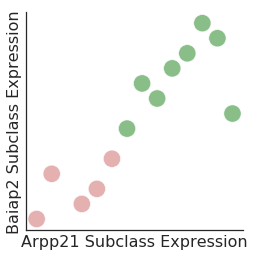

In [2433]:
ax = plot_cluster_simple('Arpp21','Baiap2',glut_expression,'subclass_label',ranking=True)
ax.set(xticks=[],yticks=[],aspect='equal')
ax.set_xlabel('Arpp21 Subclass Expression',fontsize=16)
ax.set_ylabel('Baiap2 Subclass Expression',fontsize=16)
plt.savefig('/home/bharris/biccn_paper/figures/figure4/draft_rank/arpp21_baiap2_class.pdf',transparent=True)

In [ ]:
g=plot_cluster_simple_split('Arpp21',
                            'Baiap2',
                            glut_expression,
                            'subclass_label',
                            ['Glutamatergic','GABAergic'],
                            ranking=True,
                            share=True)
g.set(xticks=[],yticks=[], aspect='equal')
g.set_xlabels('Arpp21 Subclass Expression')
g.set_ylabels('Baiap2 Subclass Expression')
plt.savefig('/home/bharris/biccn_paper/figures/figure4/draft_rank/arpp21_baiap2_subclass.pdf',transparent=True)

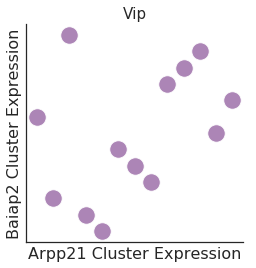

In [2428]:
ax=plot_subclass_scatter('Vip','Arpp21','Baiap2',top_genes,color=sns.desaturate(subclass_colors2['Vip'],.5), ranking=True)
ax.set(xticks=[],yticks=[],aspect='equal', title='Vip')
ax.set_xlabel('Arpp21 Cluster Expression',fontsize=16)
ax.set_ylabel('Baiap2 Cluster Expression',fontsize=16)
plt.savefig('/home/bharris/biccn_paper/figures/figure4/draft_rank/arpp21_baiap2_vip.pdf',transparent=True)

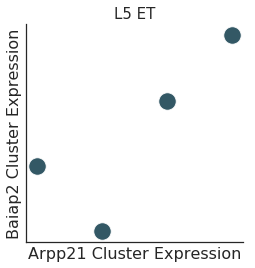

In [2429]:
ax=plot_subclass_scatter('L5_ET','Arpp21','Baiap2',top_genes,color=sns.desaturate(subclass_colors2['L5_ET'],.5), ranking=True)
ax.set(xticks=[],yticks=[], aspect='equal',title='L5 ET')
ax.set_xlabel('Arpp21 Cluster Expression',fontsize=16)
ax.set_ylabel('Baiap2 Cluster Expression',fontsize=16)
plt.savefig('/home/bharris/biccn_paper/figures/figure4/draft_rank/arpp21_baiap2_l5et.pdf',transparent=True)

### Spock3 Abat

In [ ]:
ax = plot_cluster_simple('Spock3','Abat',gaba_expression,'subclass_label',ranking=True)
ax.set(xticks=[],yticks=[],aspect='equal')
ax.set_xlabel('Spock3 Subclass Expression',fontsize=16)
ax.set_ylabel('Abat Subclass Expression',fontsize=16)
plt.tight_layout()
plt.savefig('/home/bharris/biccn_paper/figures/figure4/draft_rank/spock_abat_class.pdf',transparent=True)

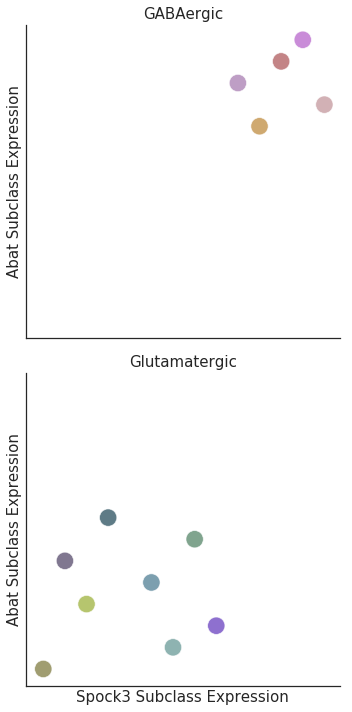

In [2414]:
g=plot_cluster_simple_split('Spock3',
                            'Abat',
                            gaba_expression,
                            'subclass_label',
                            ['GABAergic','Glutamatergic'],
                            ranking=True,
                                share=True)
g.set(xticks=[],yticks=[], aspect='equal')
g.set_xlabels('Spock3 Subclass Expression')
g.set_ylabels('Abat Subclass Expression')
plt.tight_layout()
plt.savefig('/home/bharris/biccn_paper/figures/figure4/draft_rank/spock_abat_subclass.pdf',transparent=True)

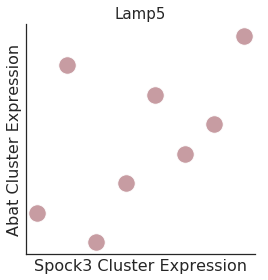

In [2426]:
ax=plot_subclass_scatter('Lamp5','Spock3','Abat',top_genes,color=sns.desaturate(subclass_colors2['Lamp5'],.5), ranking=True)
ax.set(xticks=[],yticks=[], aspect='equal', title='Lamp5')
ax.set_xlabel('Spock3 Cluster Expression',fontsize=16)
ax.set_ylabel('Abat Cluster Expression',fontsize=16)
plt.tight_layout()
plt.savefig('/home/bharris/biccn_paper/figures/figure4/draft_rank/spock_abat_Lamp5.pdf',transparent=True)

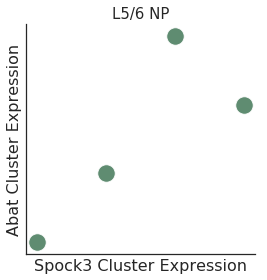

In [2427]:
ax=plot_subclass_scatter('L5_6_NP','Spock3','Abat',top_genes,color=sns.desaturate(subclass_colors2['L5_6_NP'],.5), ranking=True)
ax.set(xticks=[],yticks=[], aspect='equal', title='L5/6 NP')
ax.set_xlabel('Spock3 Cluster Expression',fontsize=16)
ax.set_ylabel('Abat Cluster Expression',fontsize=16)
plt.tight_layout()
plt.savefig('/home/bharris/biccn_paper/figures/figure4/draft_rank/spock_abat_l56np.pdf',transparent=True)

## Finding Pairs

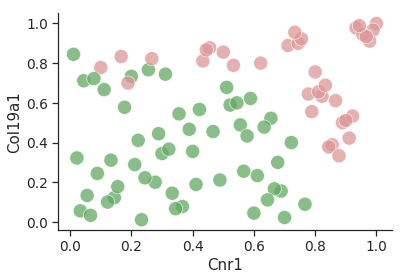

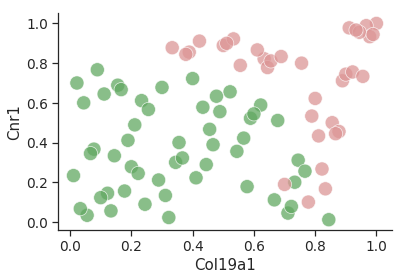

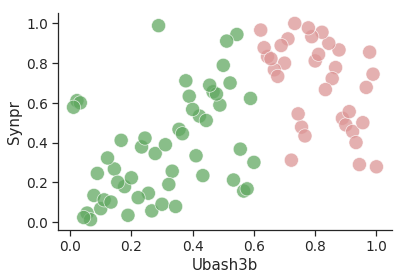

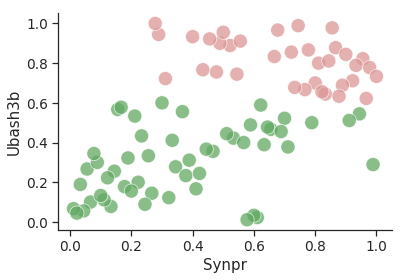

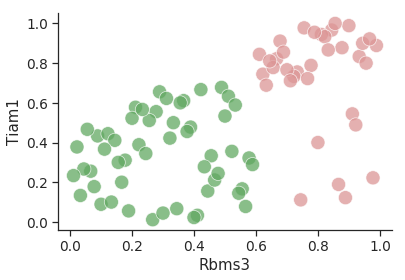

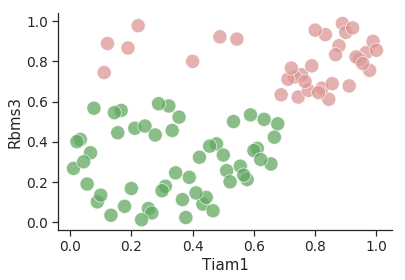

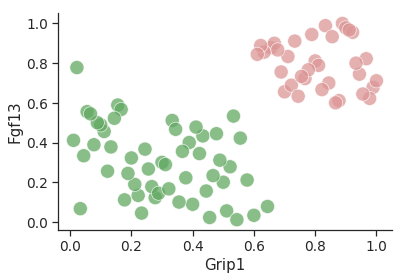

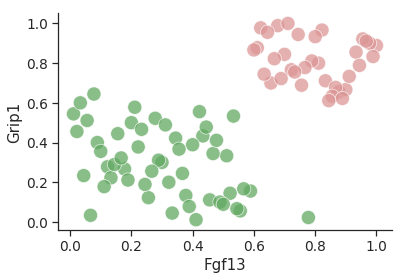

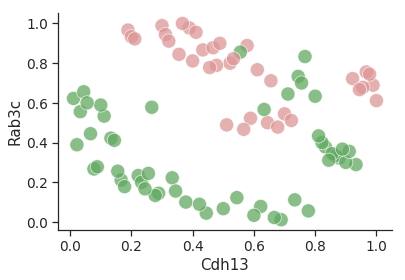

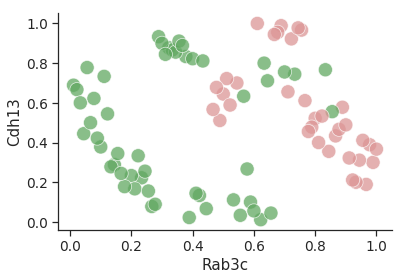

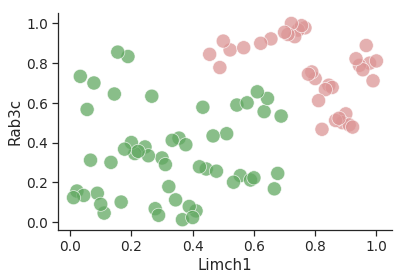

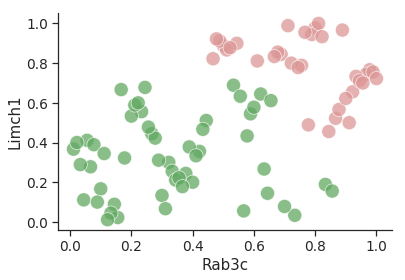

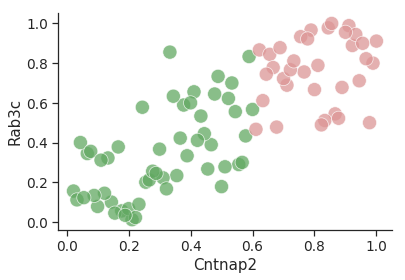

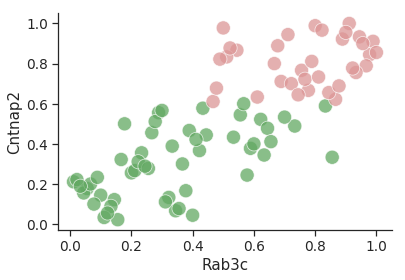

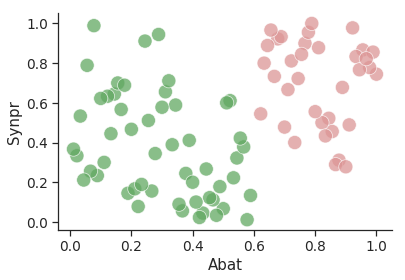

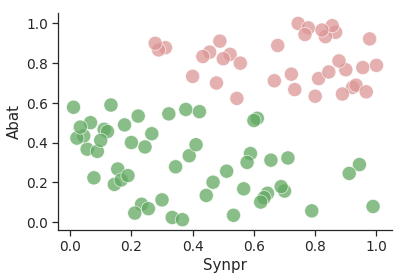

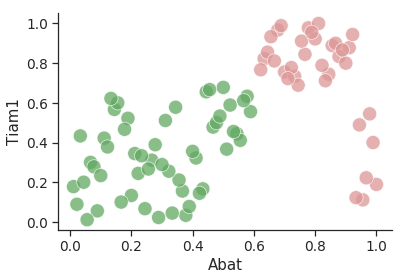

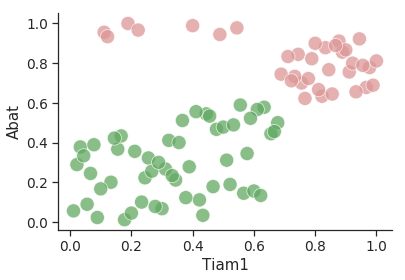

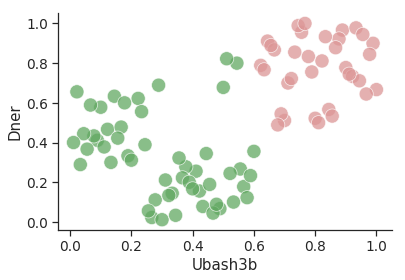

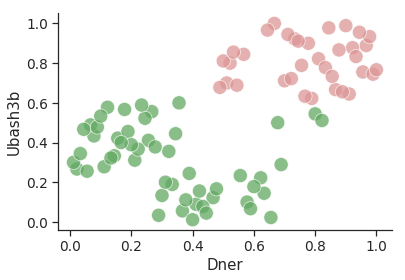

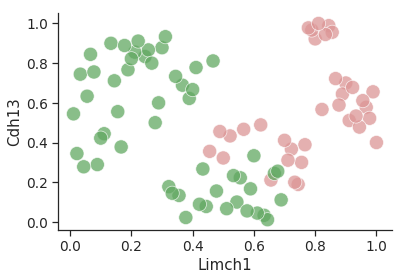

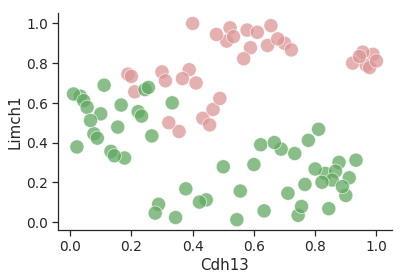

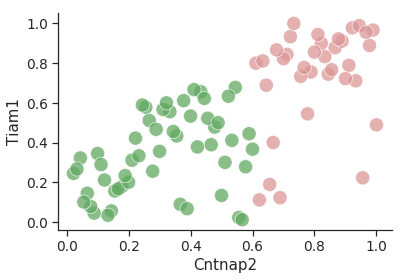

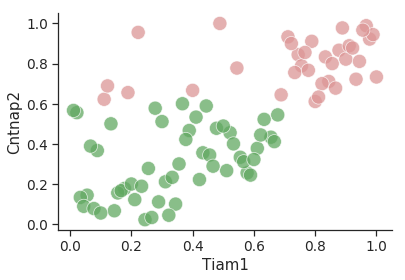

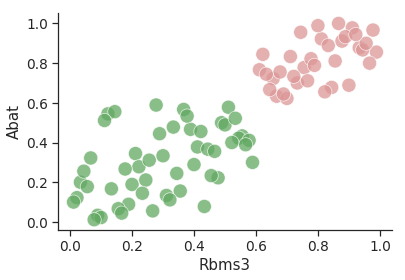

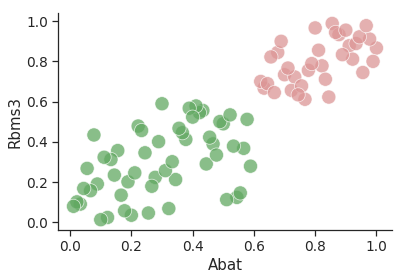

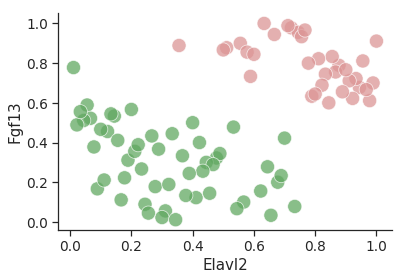

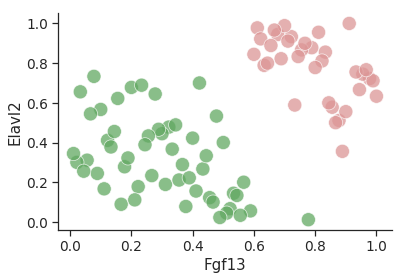

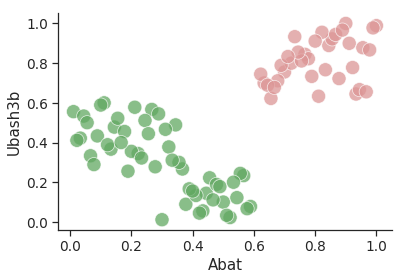

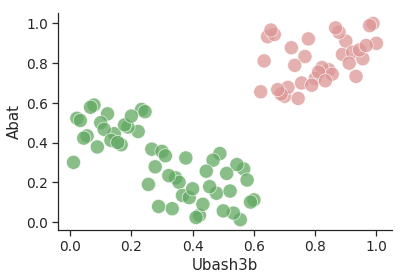

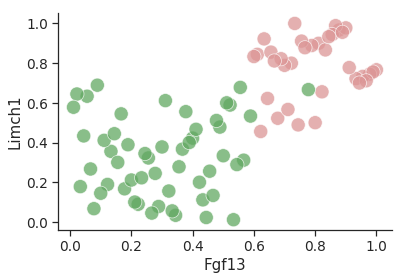

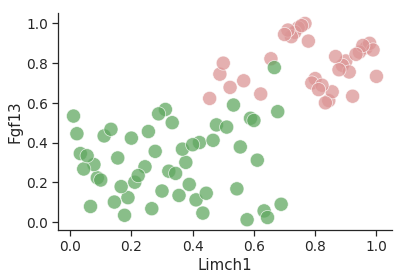

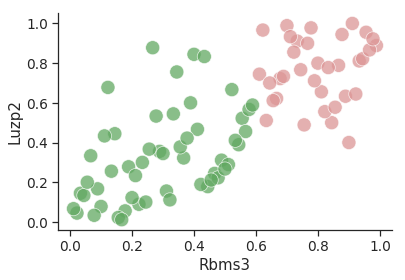

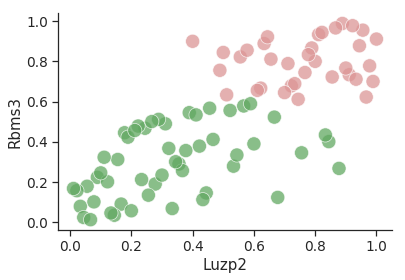

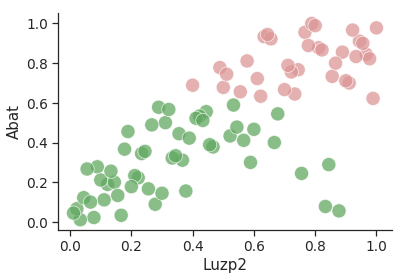

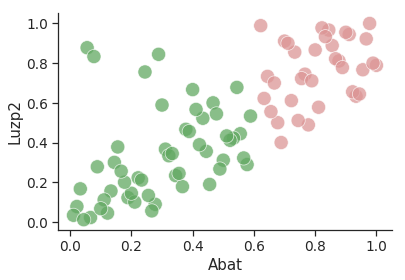

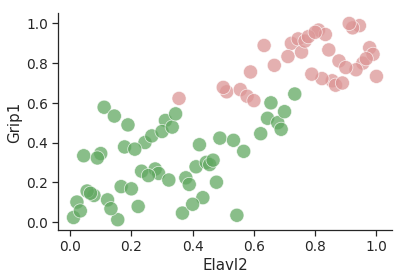

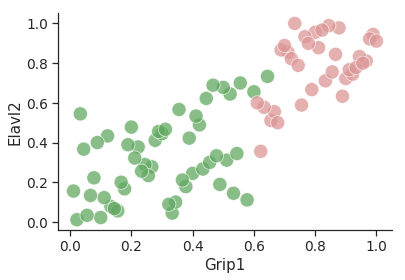

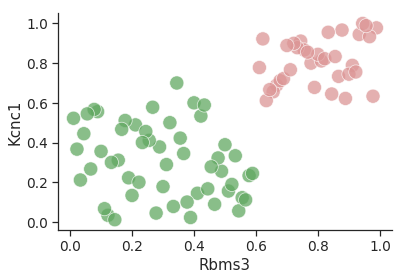

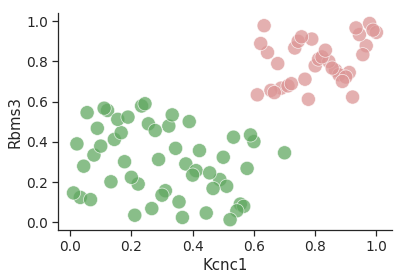

In [2286]:
temp1 = gaba_expression.groupby(['Dataset','subclass_label']).mean().reset_index()
temp2 = temp1.groupby(['Dataset']).transform(stats.zscore)
temp2['subclass_label'] = temp1.subclass_label.values

temp2['class_label'] = subclass_dict[temp2.subclass_label.values].values
temp3 = temp2.drop(columns='subclass_label').groupby('class_label')

test_func = lambda x: pd.DataFrame(np.corrcoef(x.values.T),index=top_gaba_genes,columns=top_gaba_genes)
temp4 = temp3.apply(test_func).reset_index()
temp4.columns.name='gene2'

gaba_cor = pd.melt(temp4,id_vars=['gene','class_label'])
gaba_cor.columns=['gene1','class_label','gene2','cor']
gaba_cor = pd.concat([gaba_cor[gaba_cor.class_label=='GABAergic'].reset_index(drop=True),
            gaba_cor.loc[gaba_cor.class_label=='Glutamatergic','cor'].reset_index(drop=True)],axis=1).drop(columns='class_label')
gaba_cor.columns=['gene1','gene2','GABAcor','GlutCor']
gaba_cor = gaba_cor[gaba_cor.gene1!=gaba_cor.gene2]
gaba_cor['total_cor'] = gaba_cor.GABAcor + gaba_cor.GlutCor
for a in list(zip(gaba_cor.sort_values('total_cor', ascending=False)[['gene1','gene2']].values[:40])):
    plot_cluster_simple2(a[0][0],a[0][1],gaba_expression,'subclass_label',ranking=True)

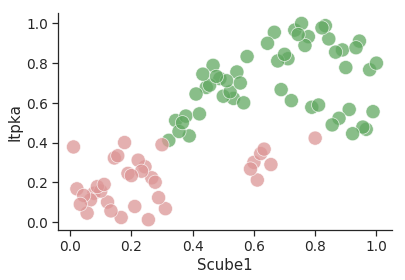

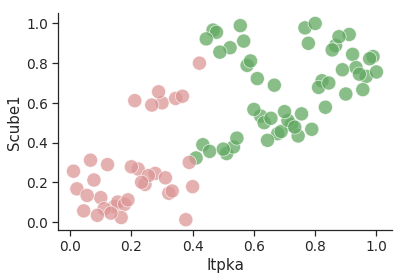

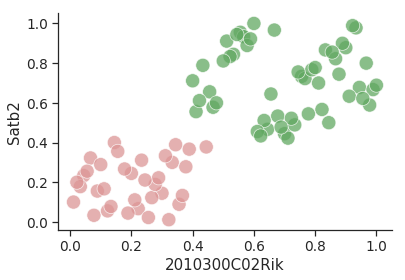

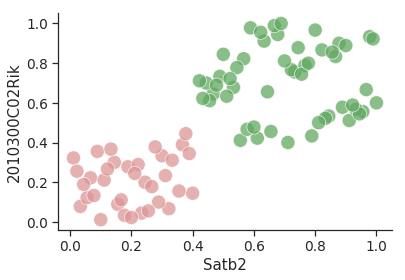

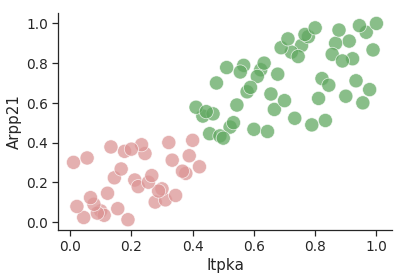

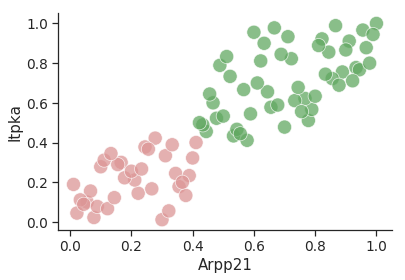

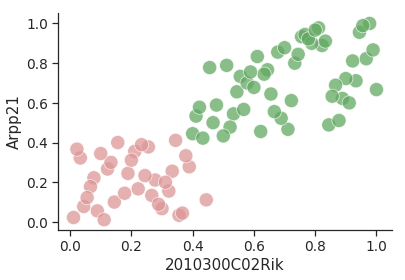

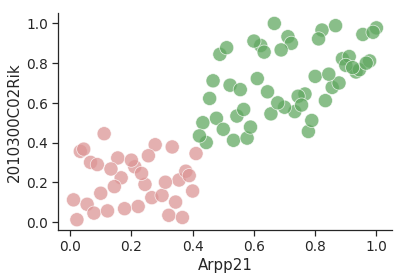

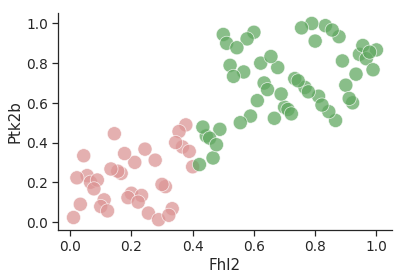

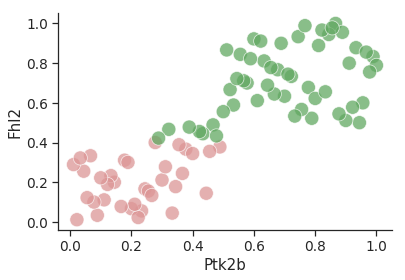

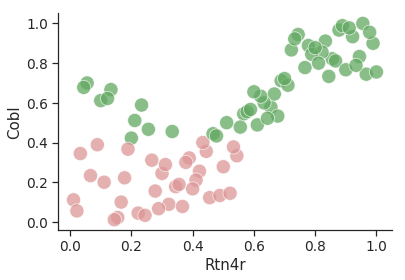

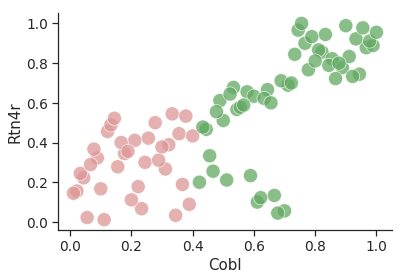

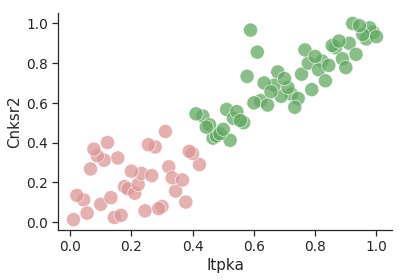

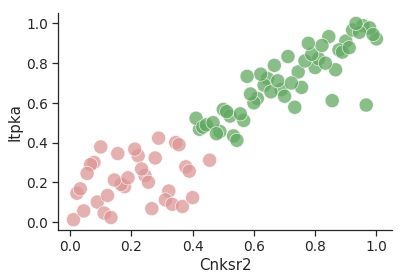

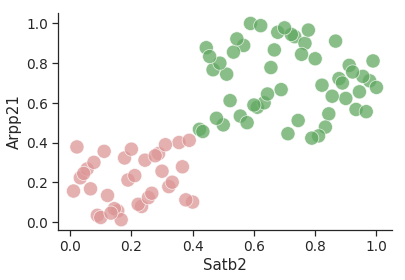

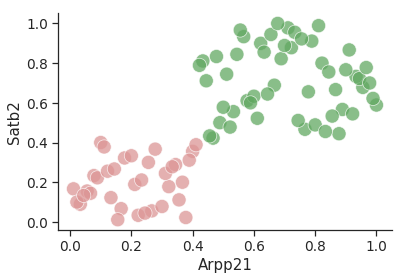

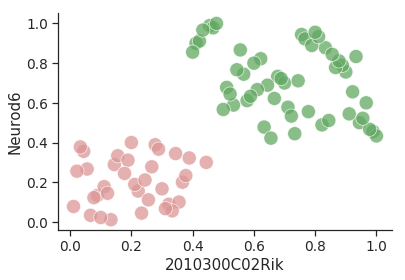

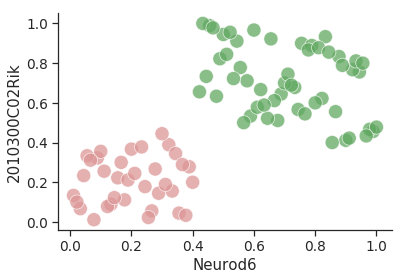

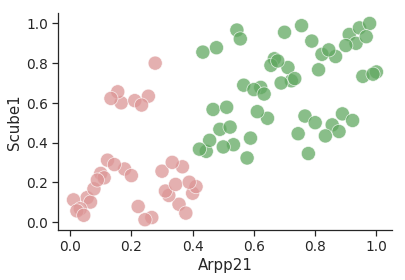

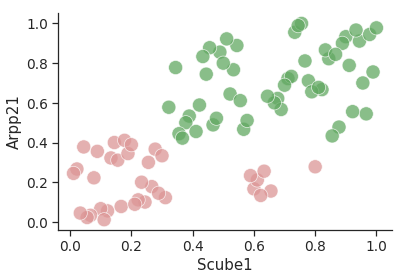

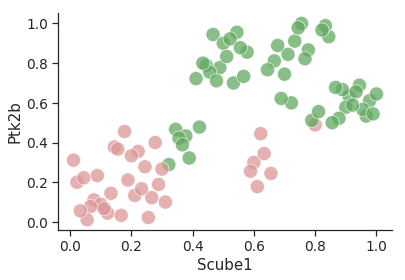

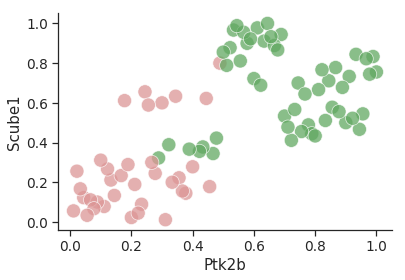

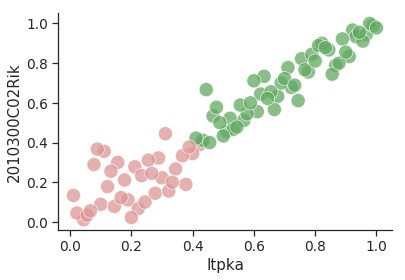

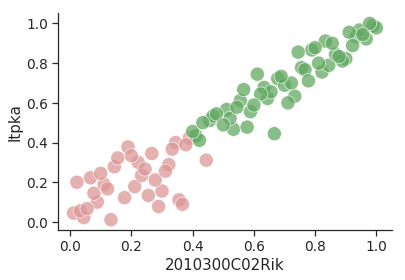

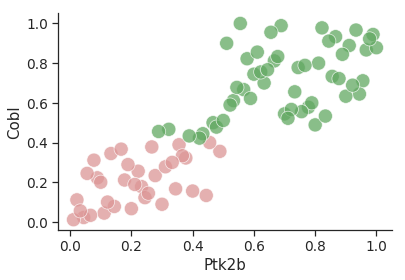

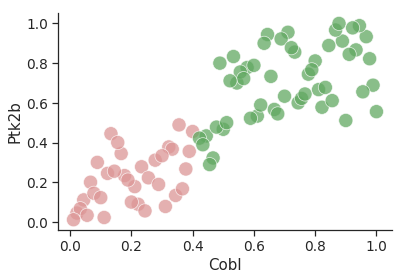

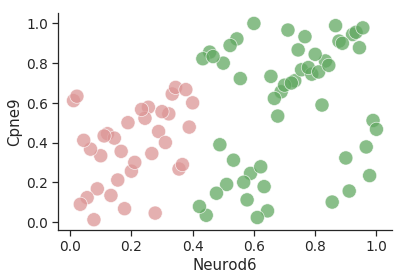

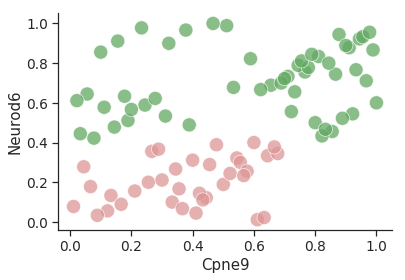

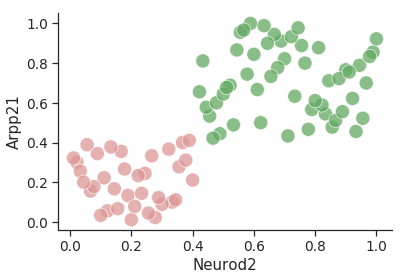

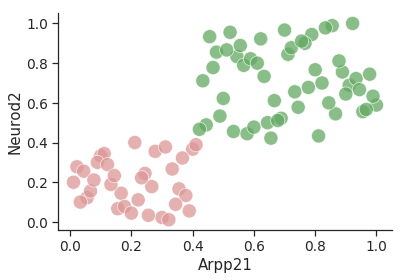

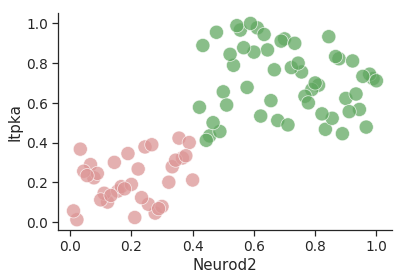

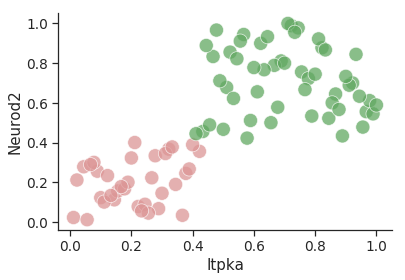

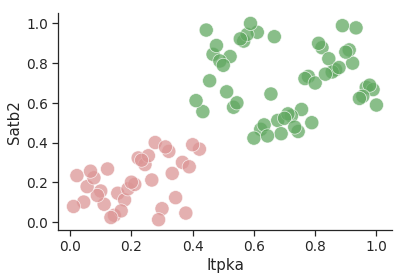

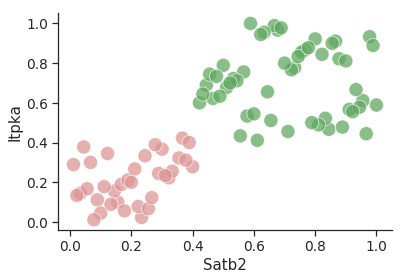

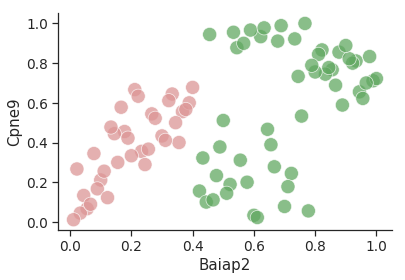

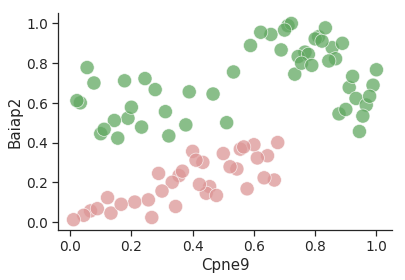

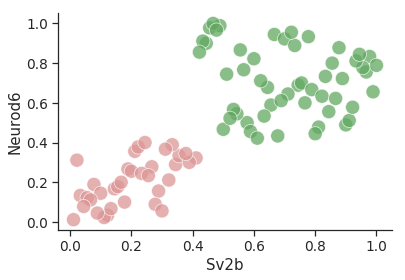

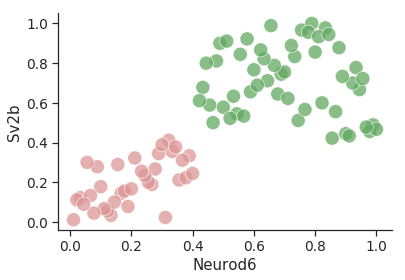

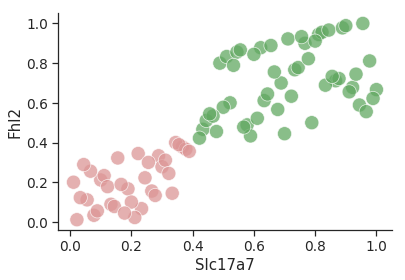

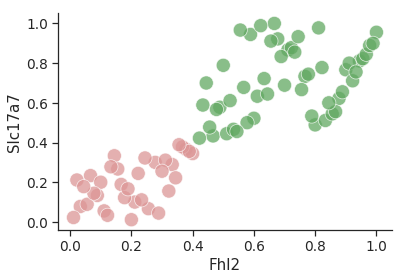

In [2273]:
temp1 = glut_expression.groupby(['Dataset','subclass_label']).mean().reset_index()
temp2 = temp1.groupby(['Dataset']).transform(stats.zscore)
temp2['subclass_label'] = temp1.subclass_label.values

temp2['class_label'] = subclass_dict[temp2.subclass_label.values].values
temp3 = temp2.drop(columns='subclass_label').groupby('class_label')

test_func = lambda x: pd.DataFrame(np.corrcoef(x.values.T),index=top_glut_genes,columns=top_glut_genes)
temp4 = temp3.apply(test_func).reset_index()
temp4.columns.name='gene2'

glut_cor = pd.melt(temp4,id_vars=['gene','class_label'])
glut_cor.columns=['gene1','class_label','gene2','cor']
glut_cor = pd.concat([glut_cor[glut_cor.class_label=='GABAergic'].reset_index(drop=True),
            glut_cor.loc[glut_cor.class_label=='Glutamatergic','cor'].reset_index(drop=True)],axis=1).drop(columns='class_label')
glut_cor.columns=['gene1','gene2','GABAcor','GlutCor']
glut_cor = glut_cor[glut_cor.gene1!=glut_cor.gene2]
glut_cor['total_cor'] = glut_cor.GABAcor + glut_cor.GlutCor
for a in list(zip(glut_cor.sort_values('total_cor', ascending=False)[['gene1','gene2']].values[:40])):
    plot_cluster_simple2(a[0][0],a[0][1],glut_expression,'subclass_label')

In [1557]:
top_genes = get_genes(top_gaba_glut)
top_genes = top_genes[~top_genes.subclass_label.isin(['Sst_Chodl','Meis2'])]

2020-03-06 08:19:23,334 - zeng_10x_cell
2020-03-06 08:22:08,364 - zeng_10x_nuc
2020-03-06 08:23:19,270 - zeng_smart_cell
2020-03-06 08:23:40,613 - zeng_smart_nuc
2020-03-06 08:23:59,196 - zeng_10x_cell_v3
2020-03-06 08:25:35,735 - zeng_10x_nuc_v3
2020-03-06 08:26:04,402 - macosko_10x_nuc_v3


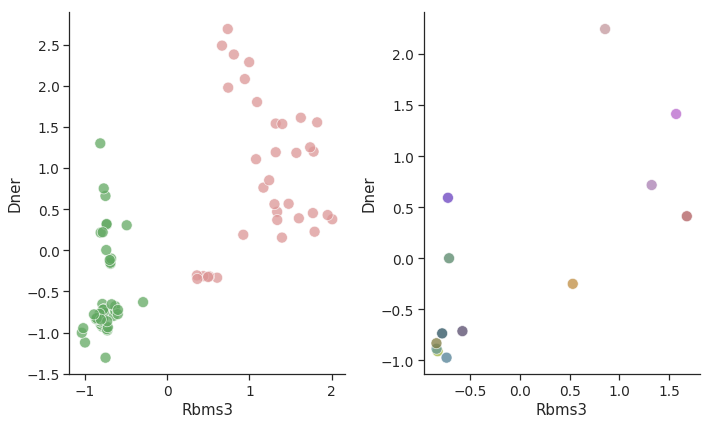

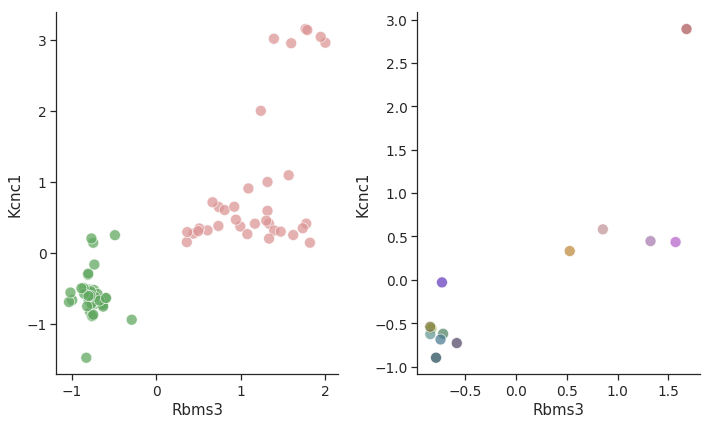

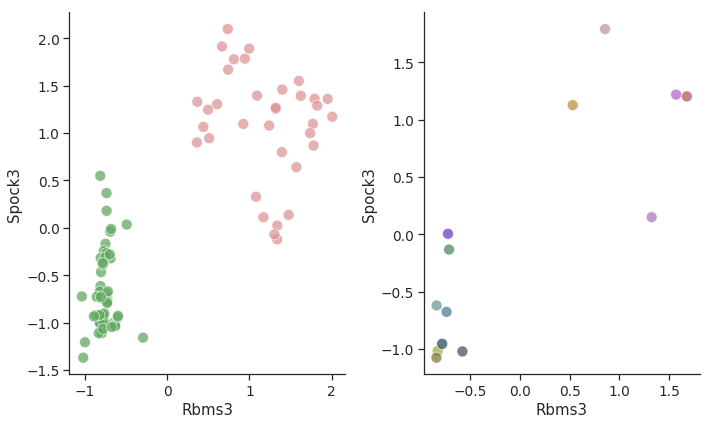

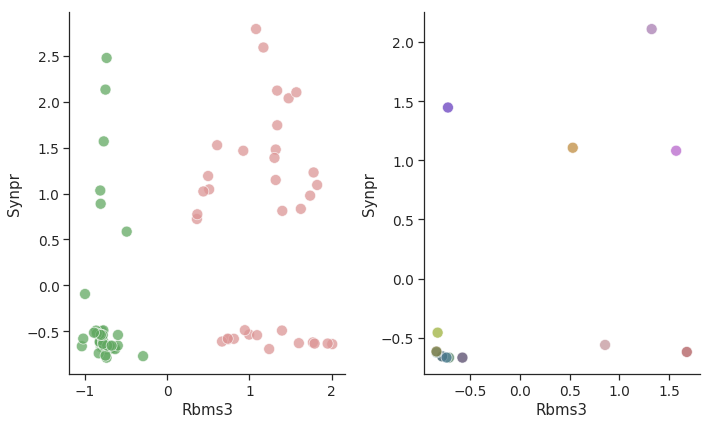

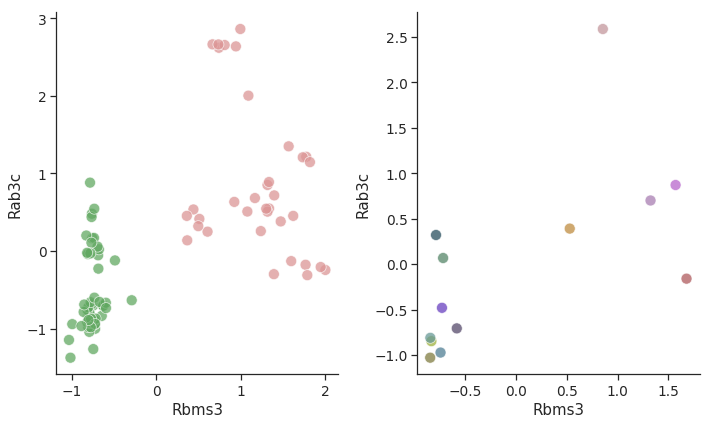

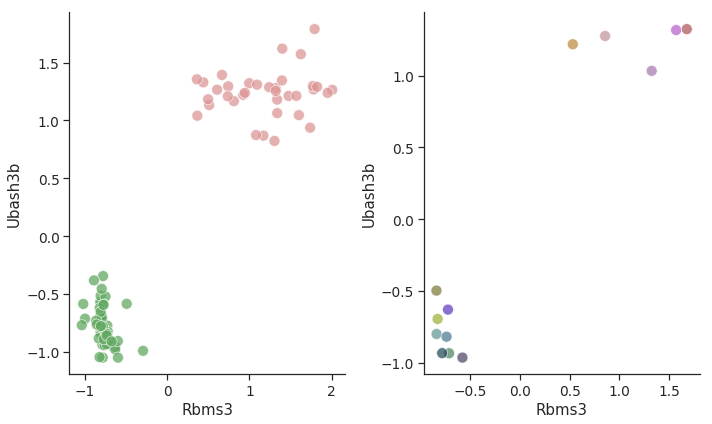

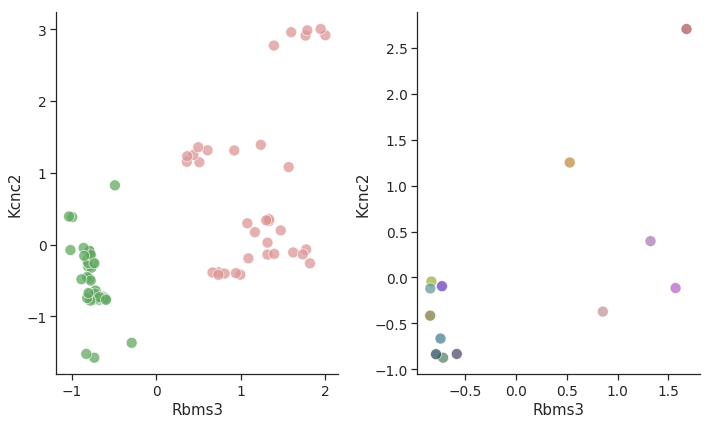

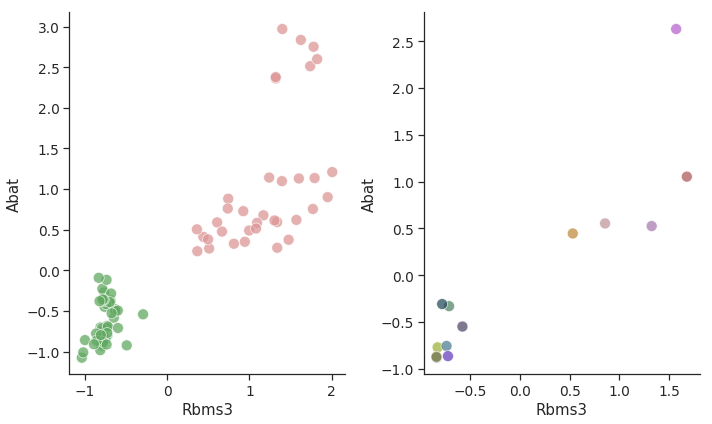

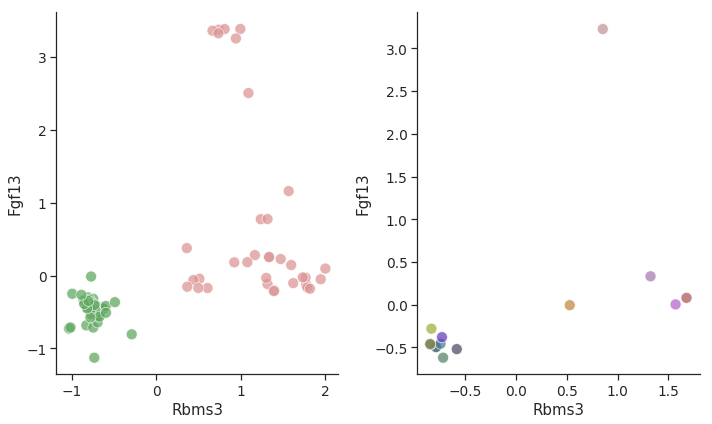

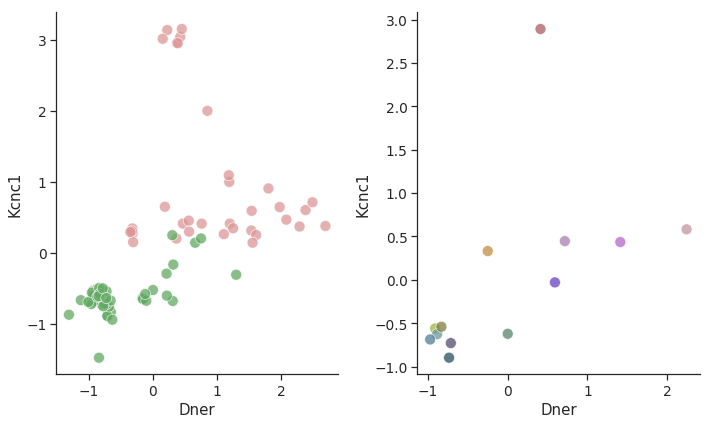

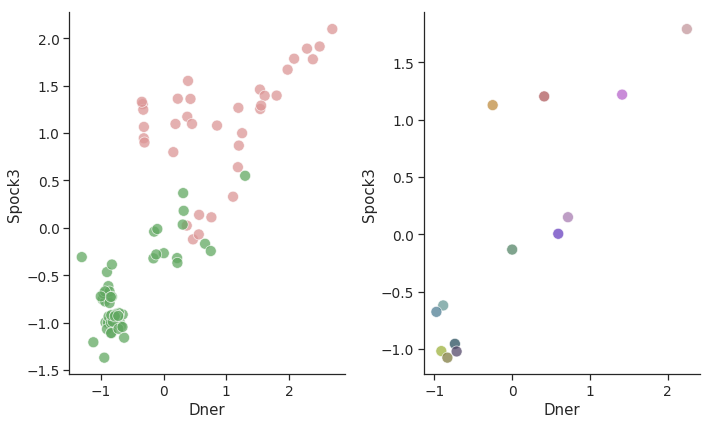

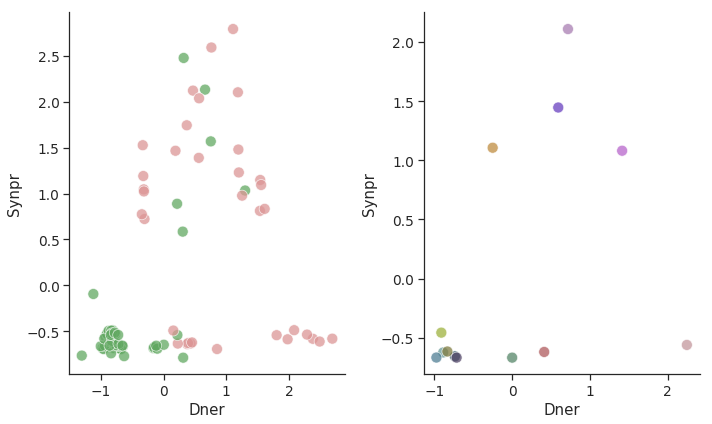

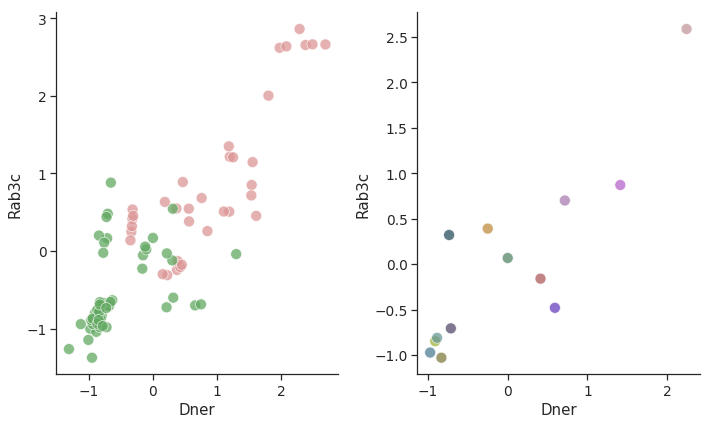

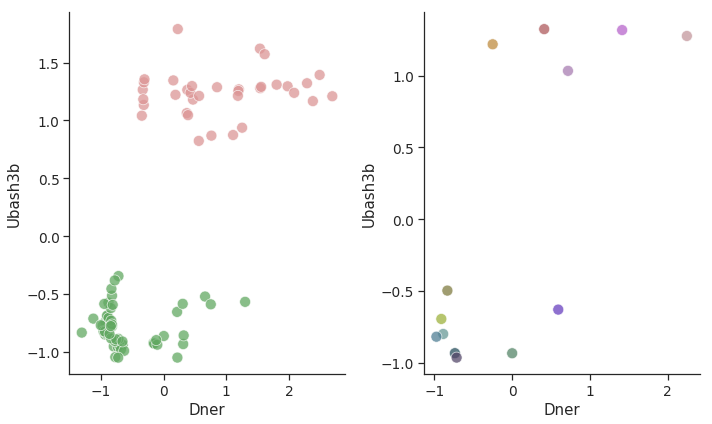

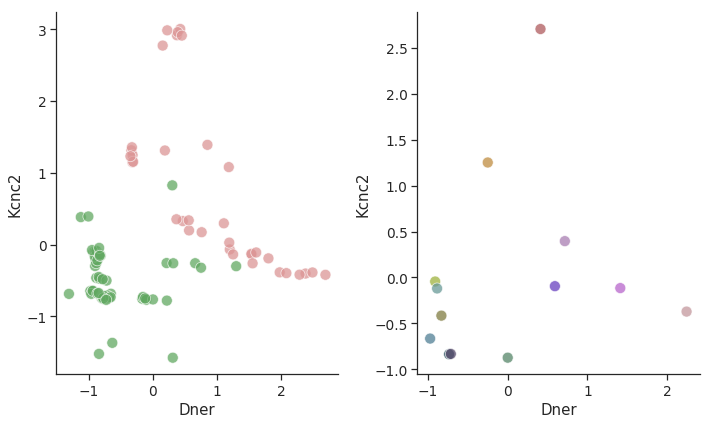

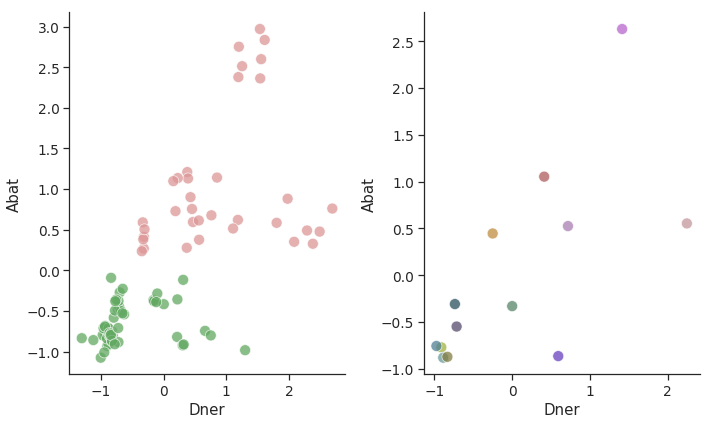

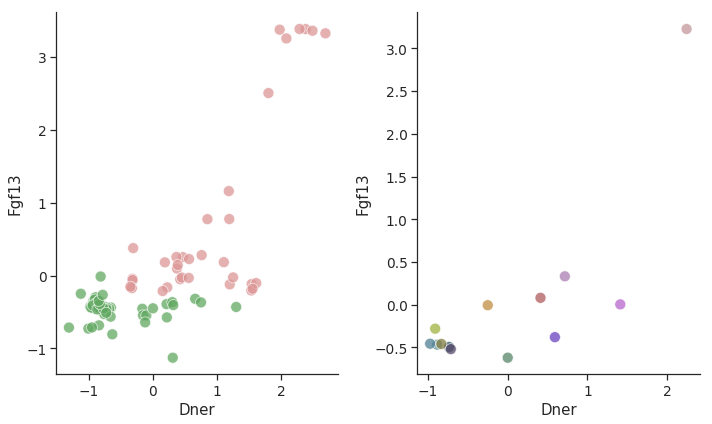

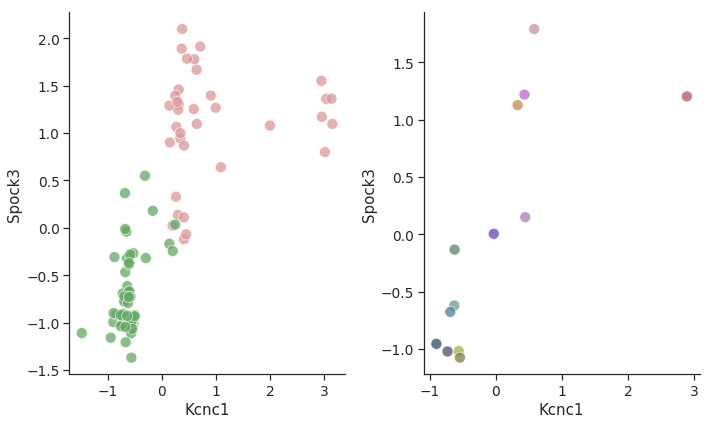

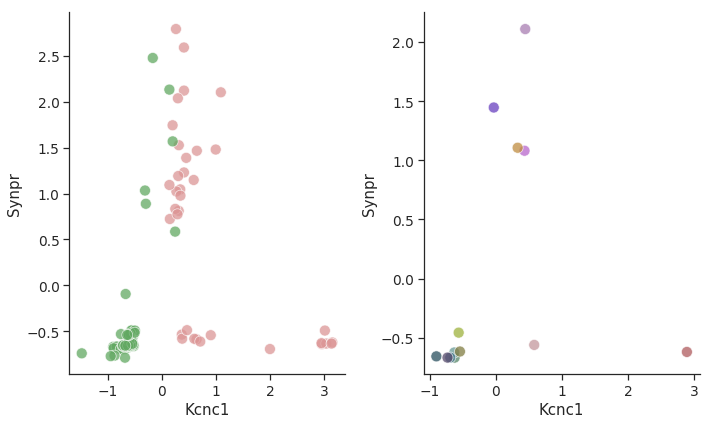

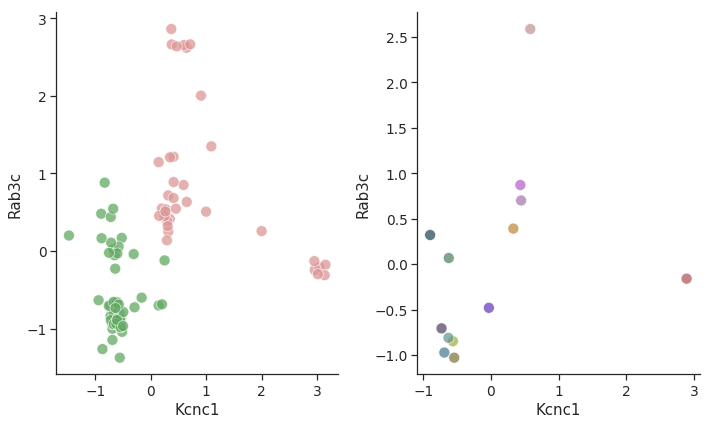

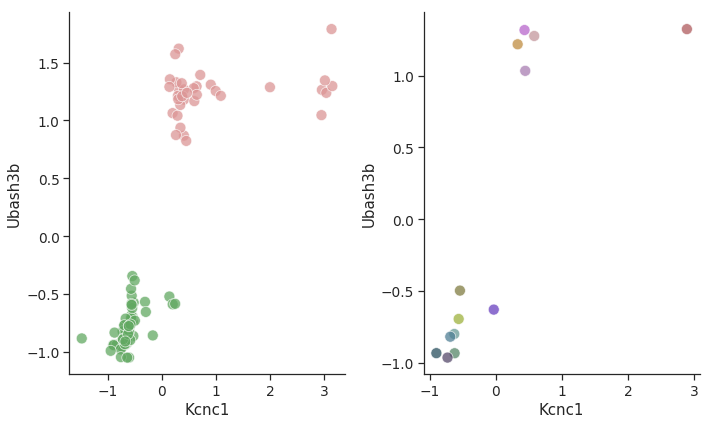

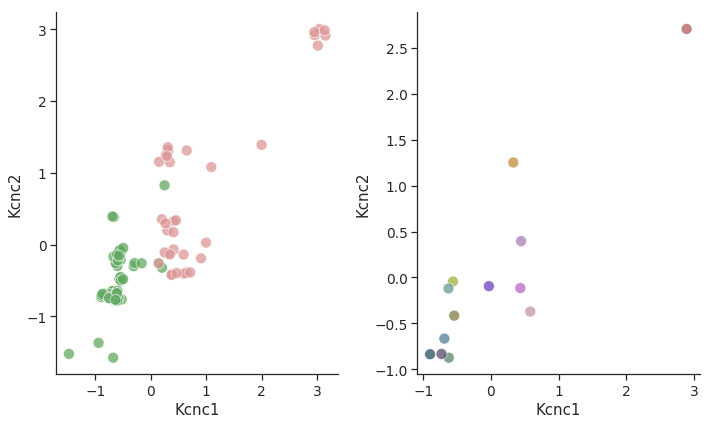

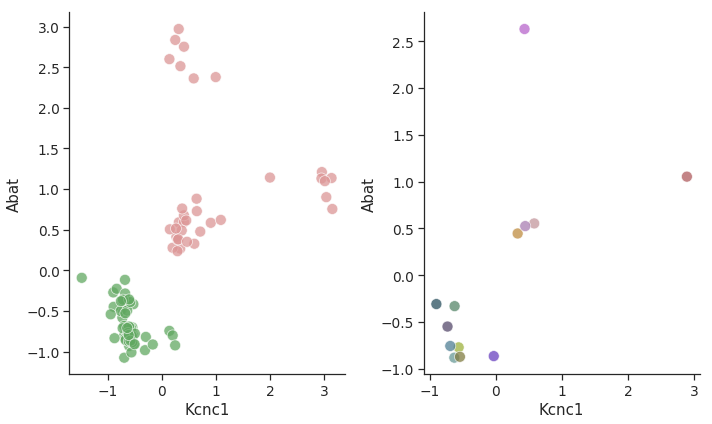

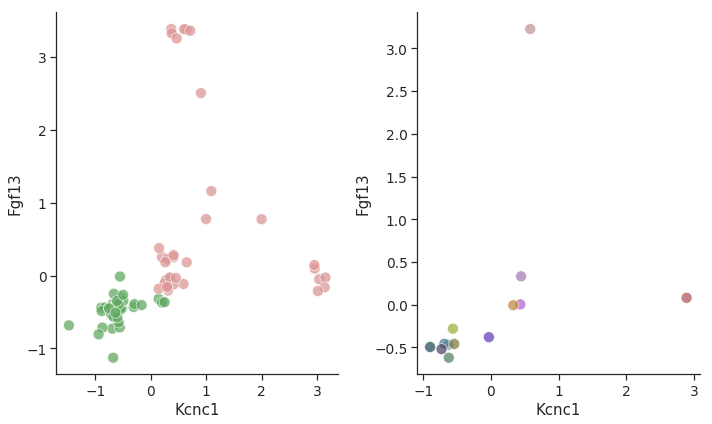

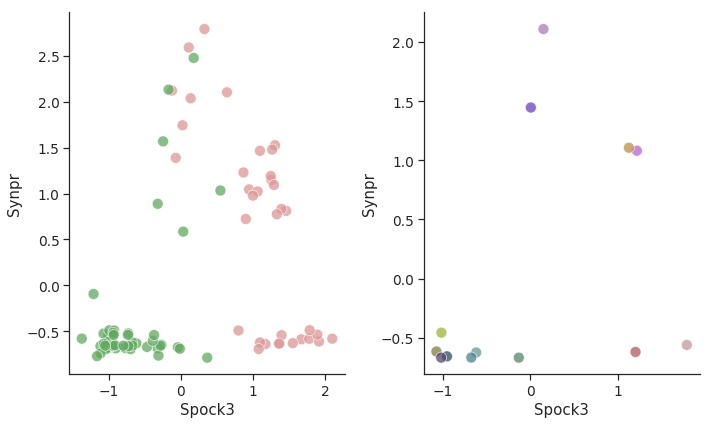

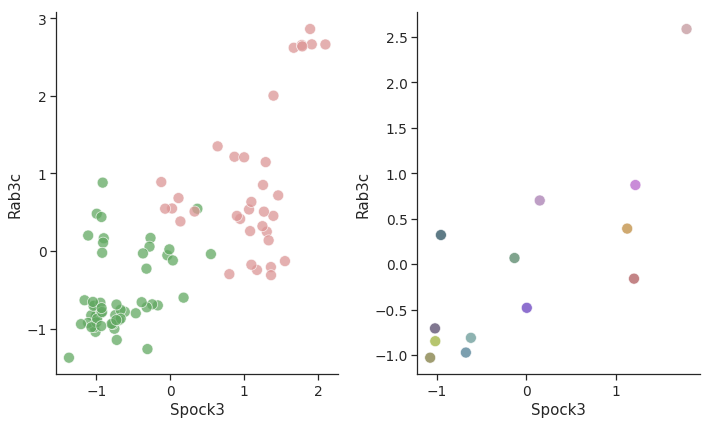

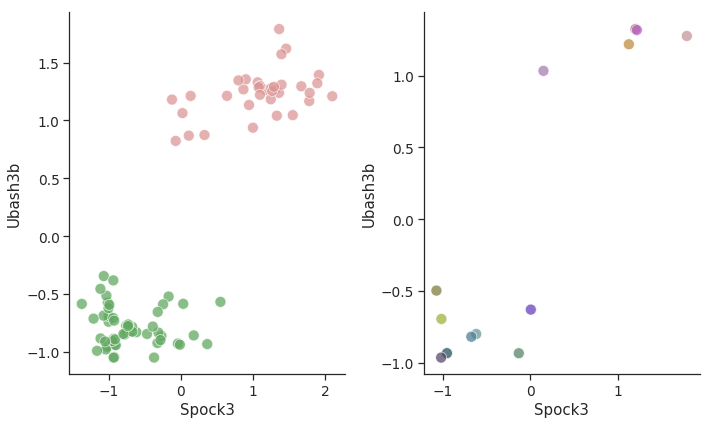

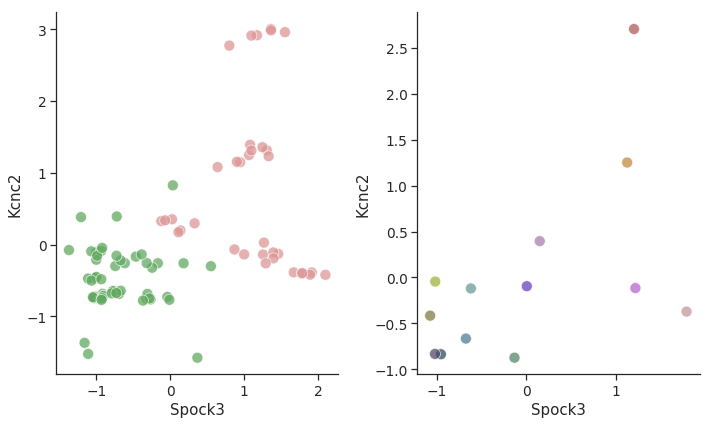

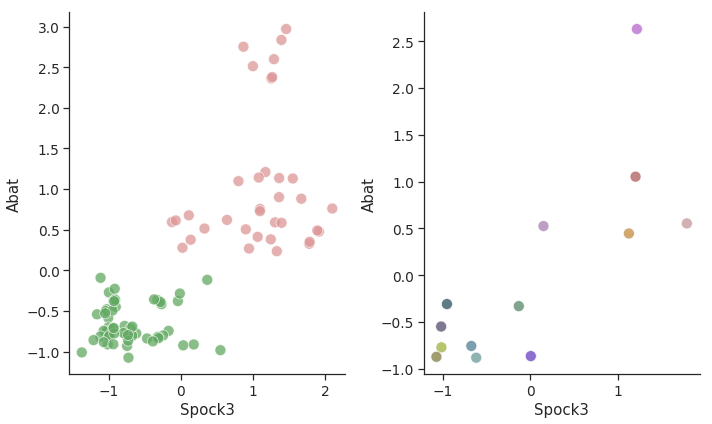

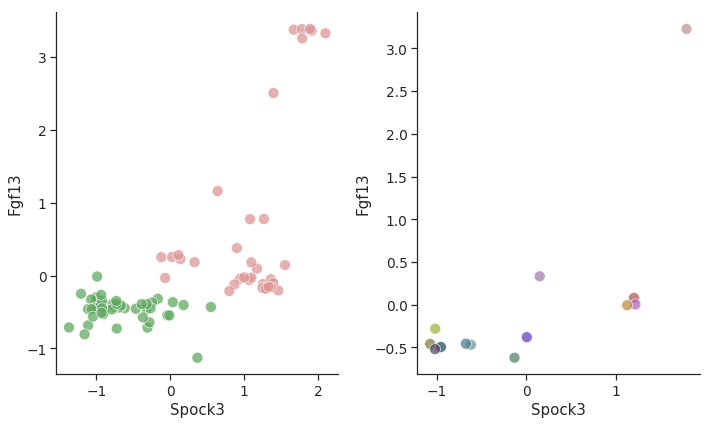

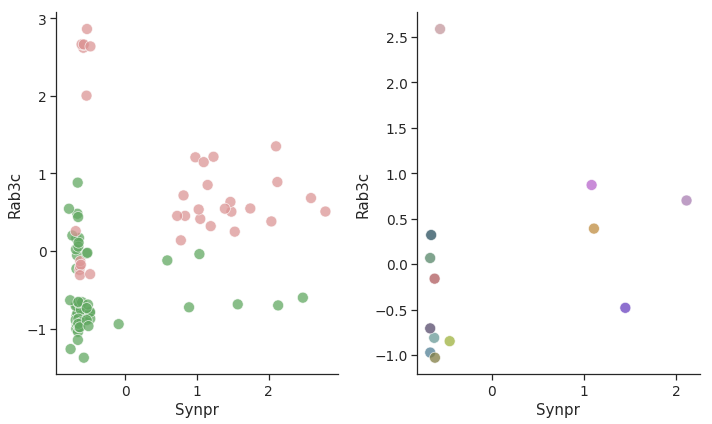

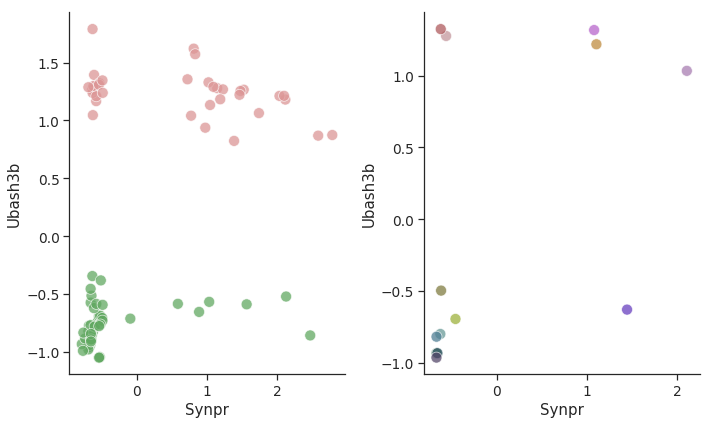

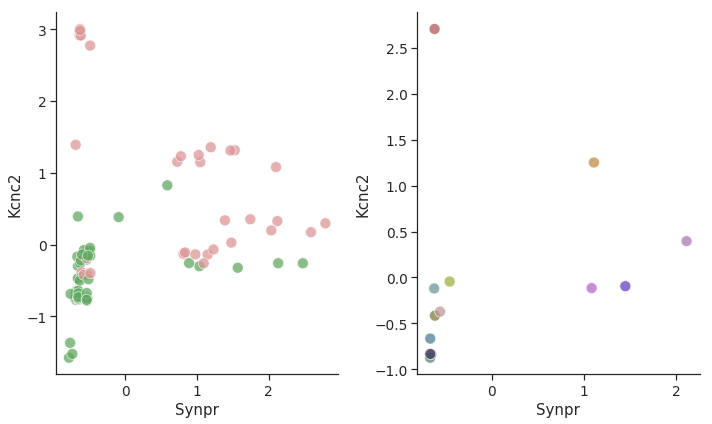

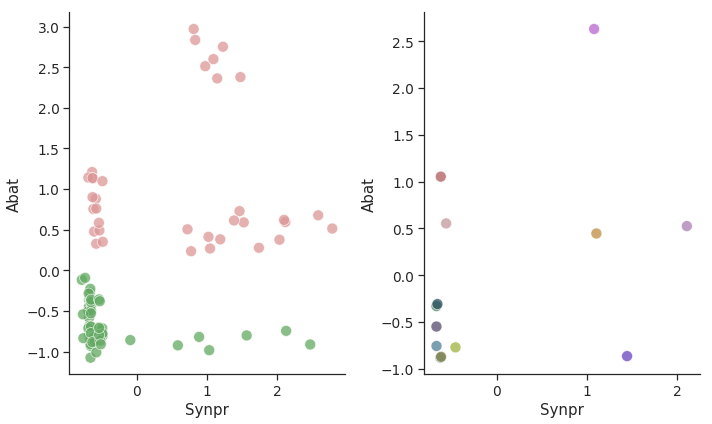

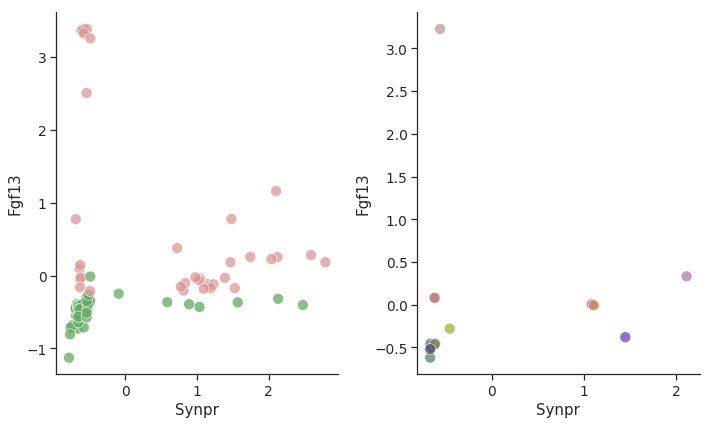

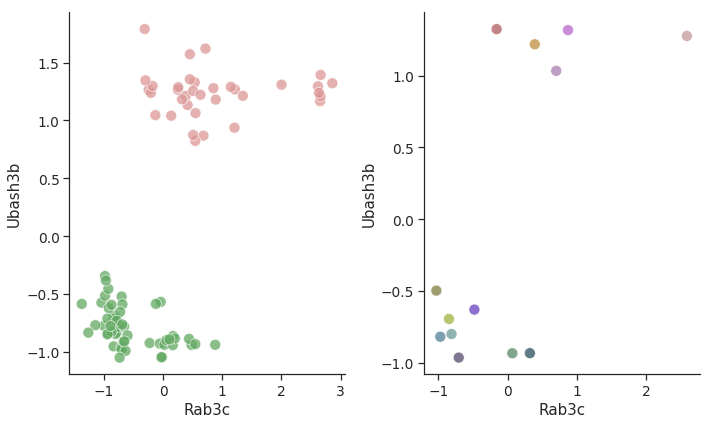

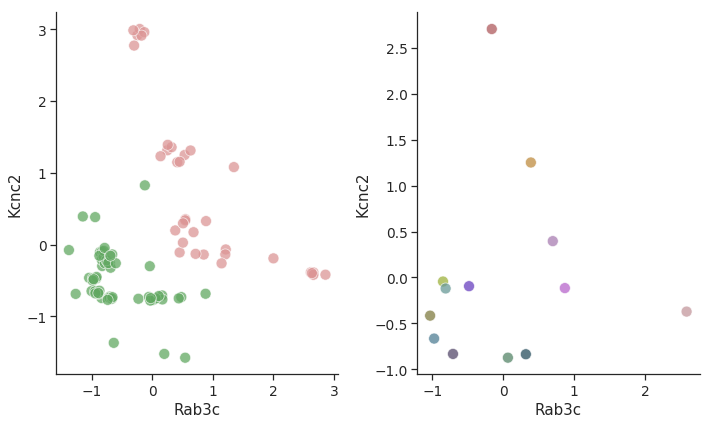

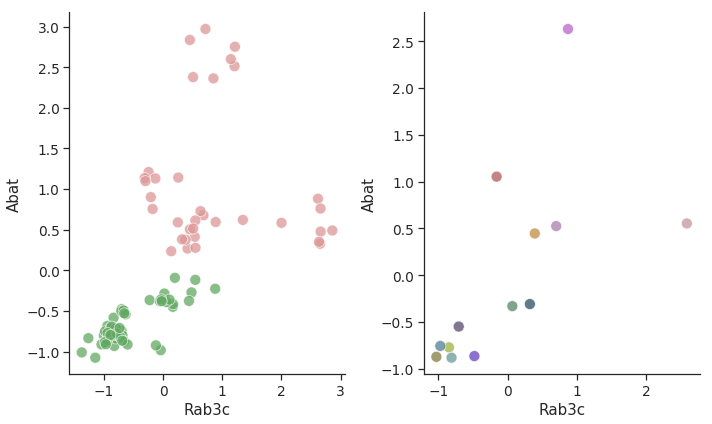

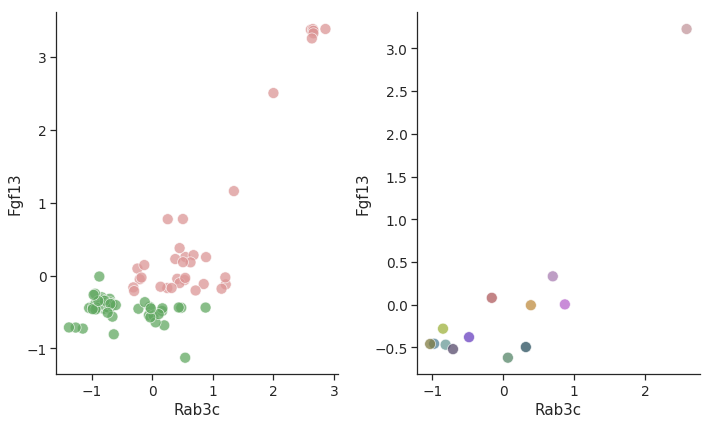

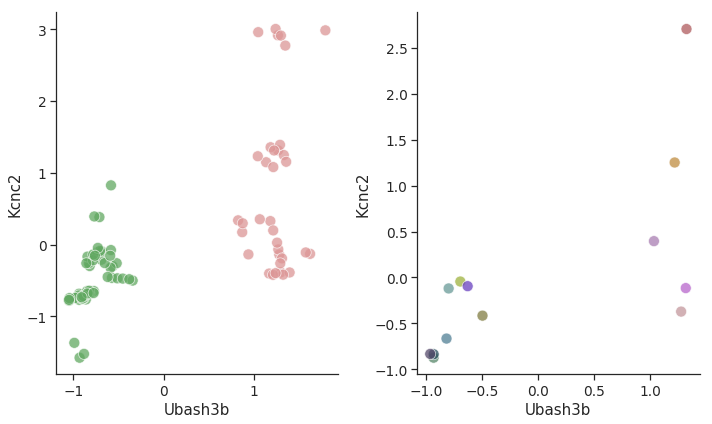

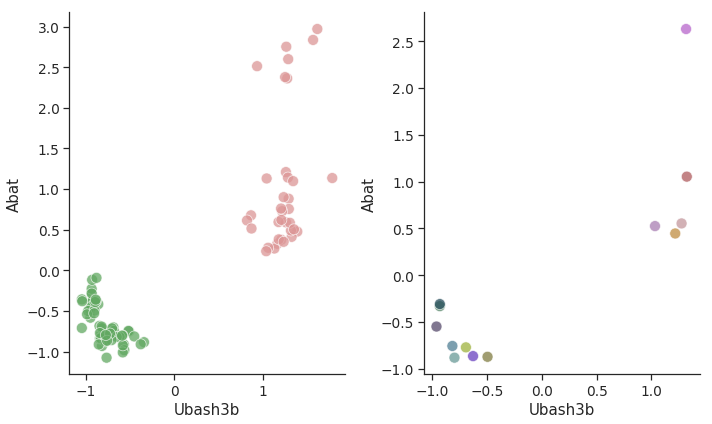

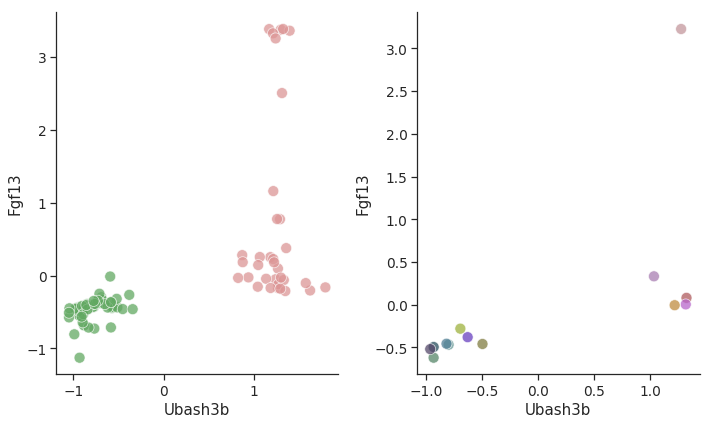

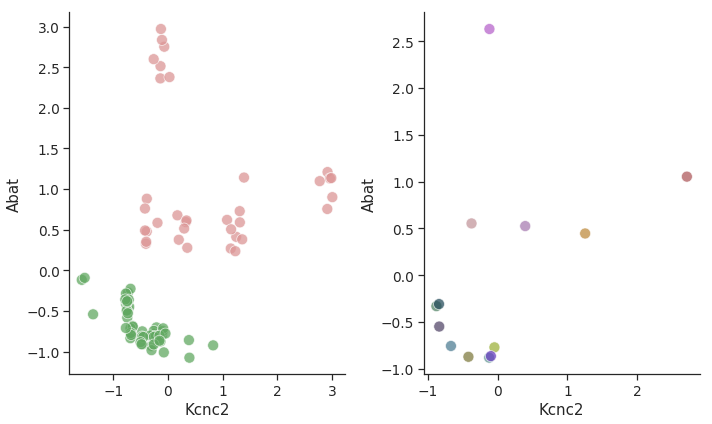

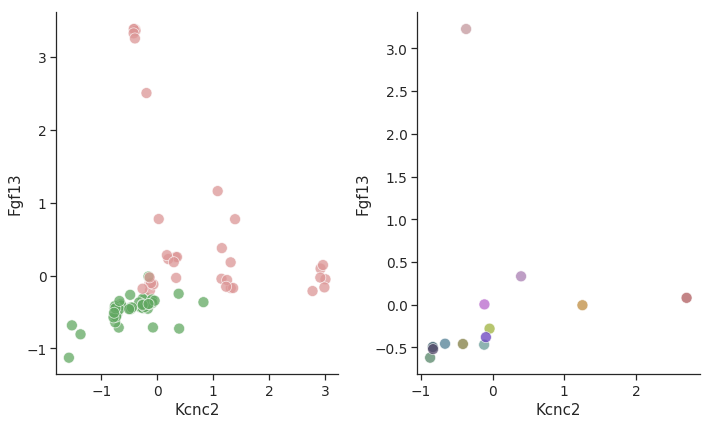

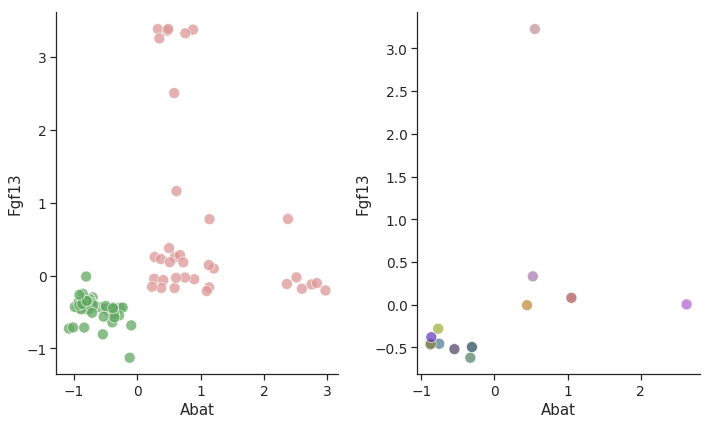

In [1584]:
for g1 ,g2 in gaba_comb:
    fig, ax = plt.subplots(figsize=(10,6), ncols=2)
    plot_class_label_scatter(top_genes,g1,g2,ax=ax[0])
    plot_class_label_scatter(top_genes,g1,g2,ax=ax[1],color='subclass_label')
    plt.tight_layout()
    plt.show()

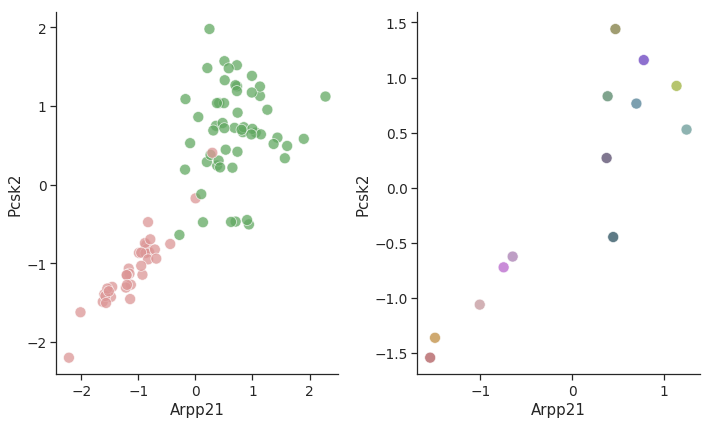

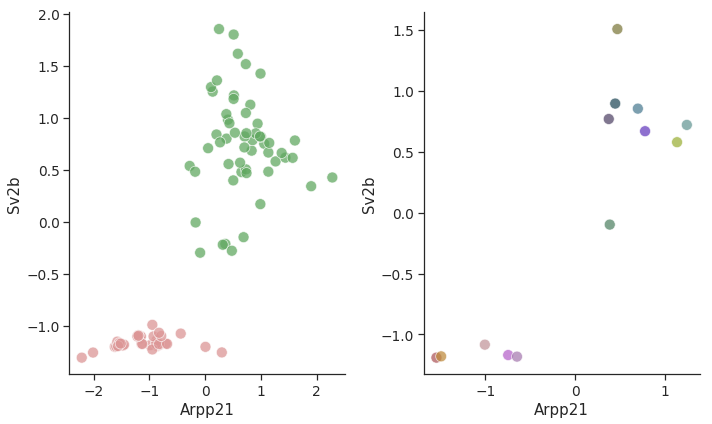

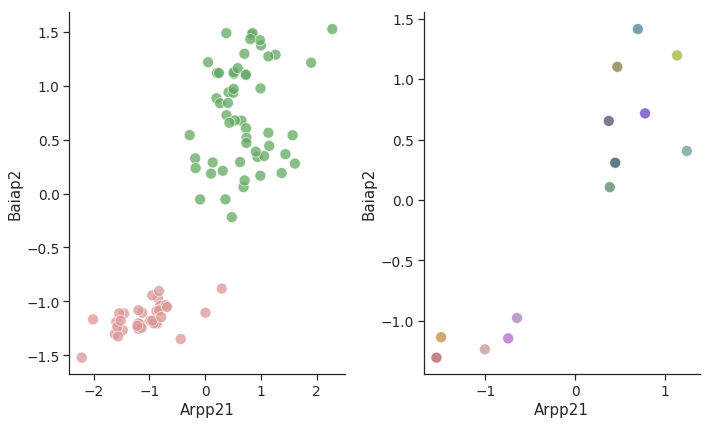

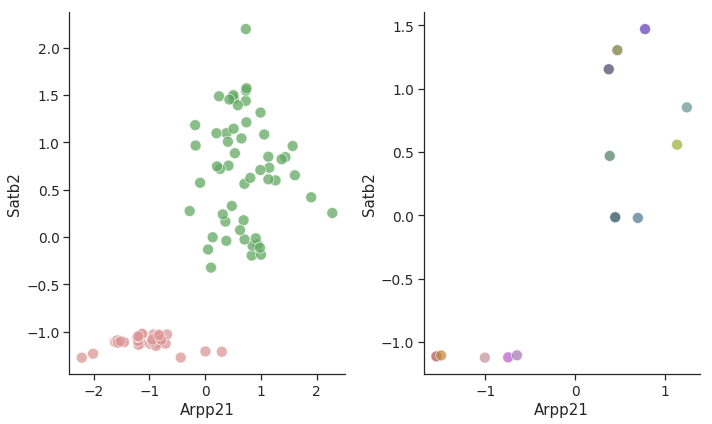

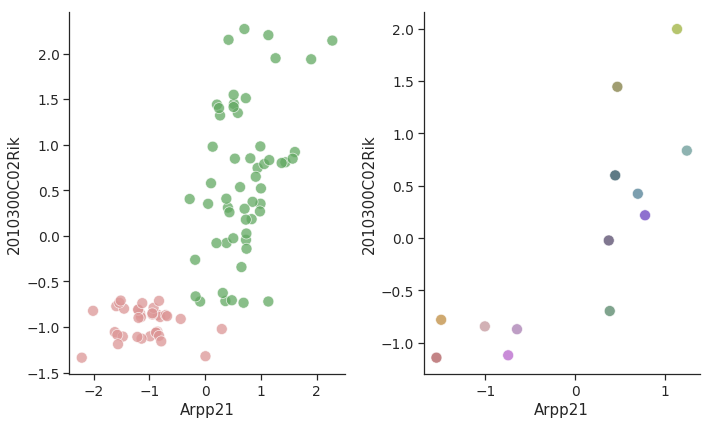

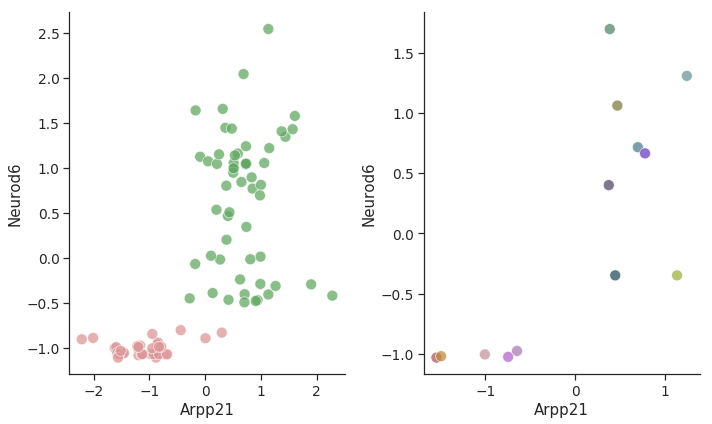

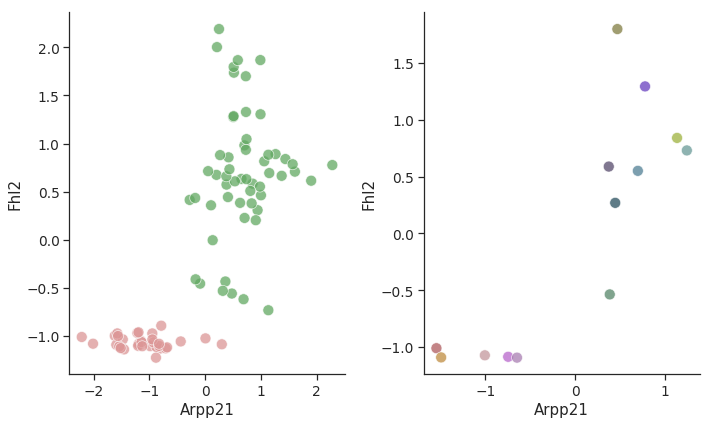

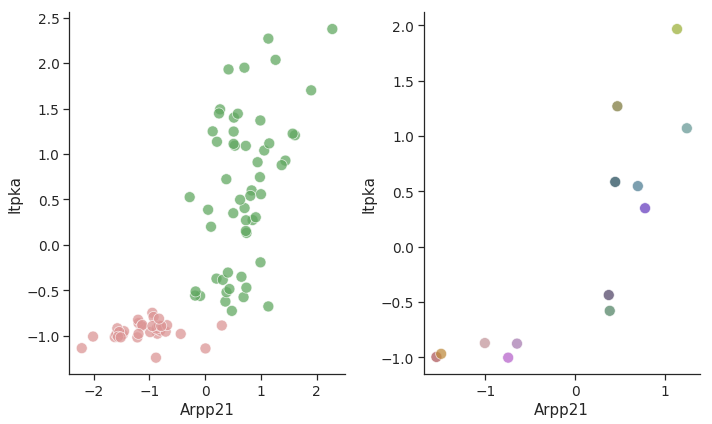

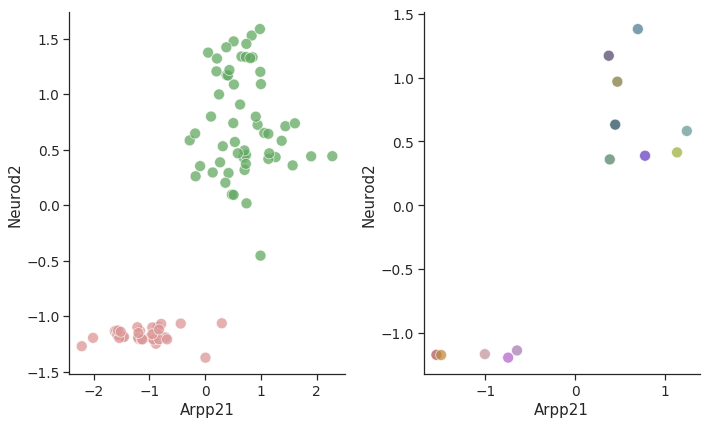

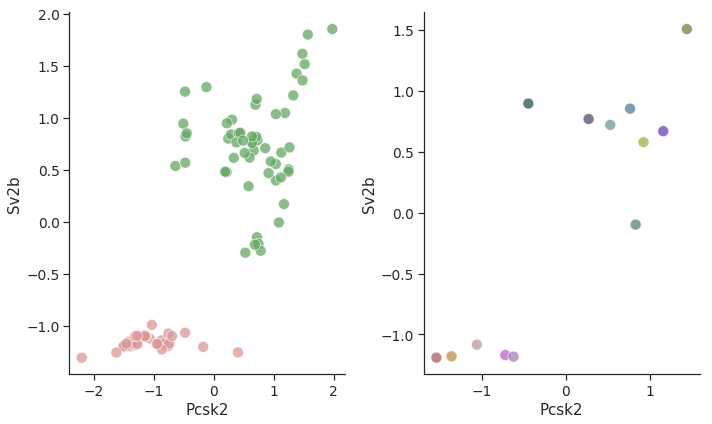

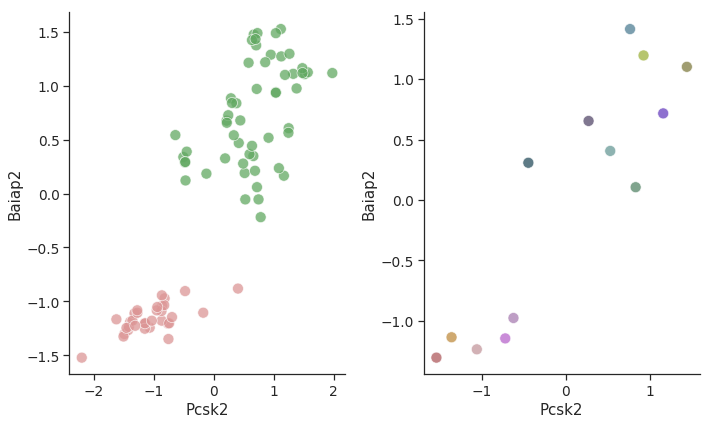

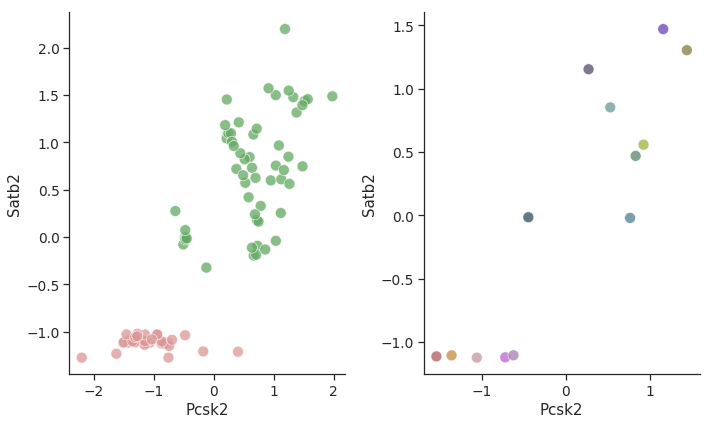

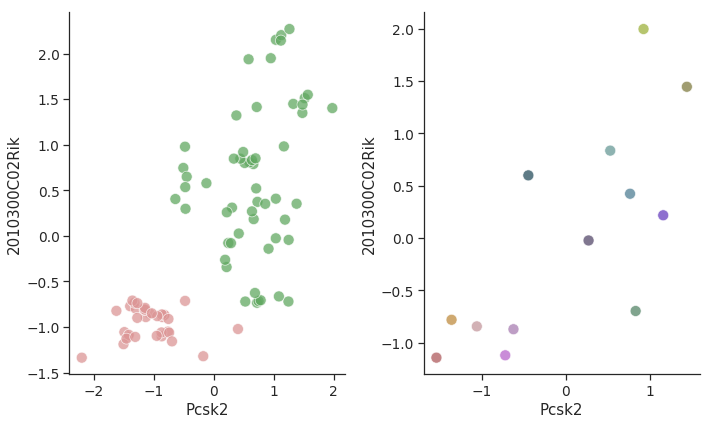

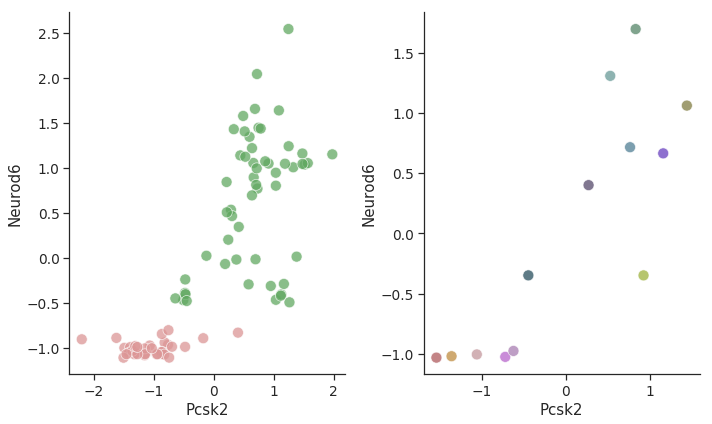

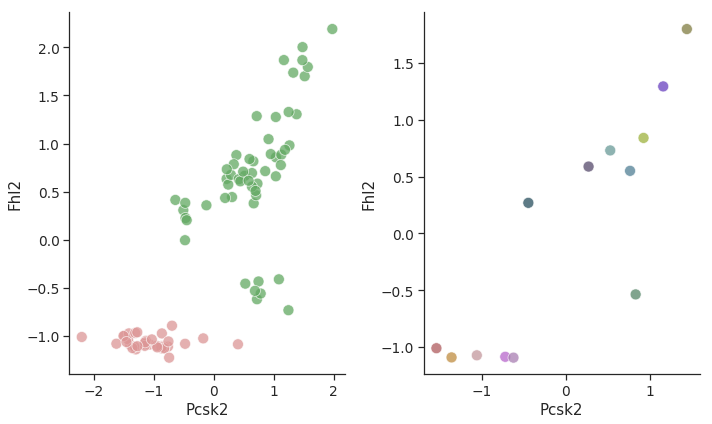

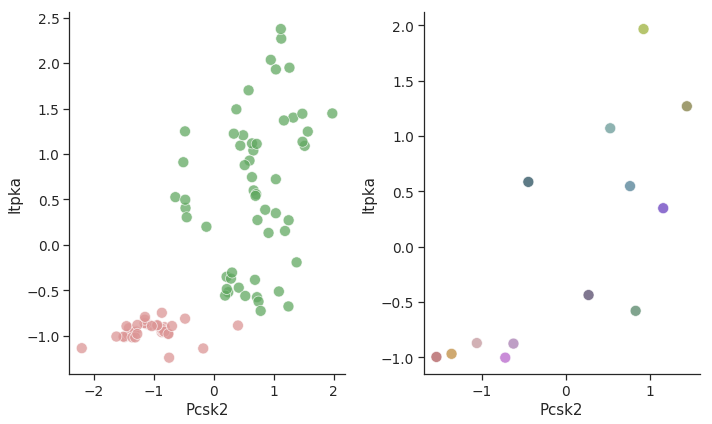

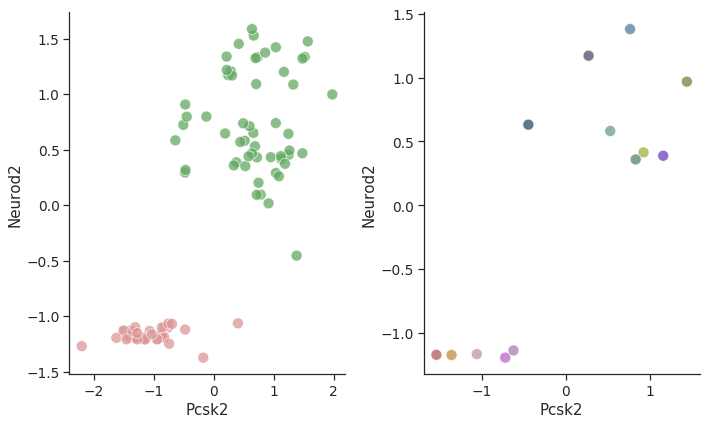

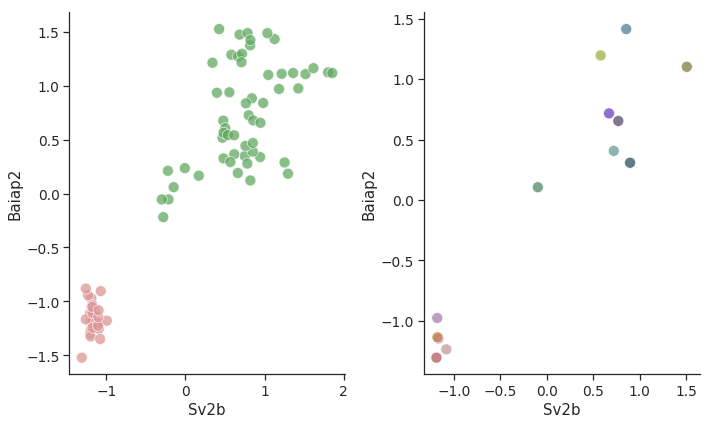

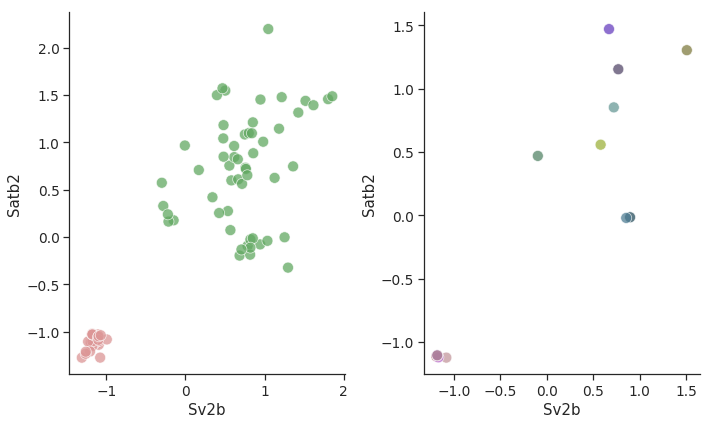

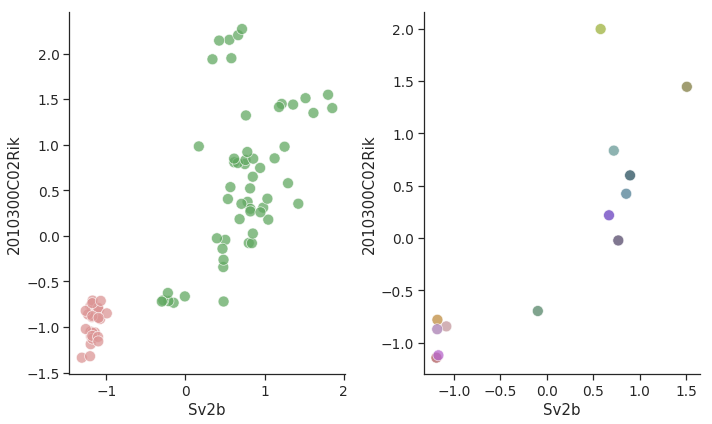

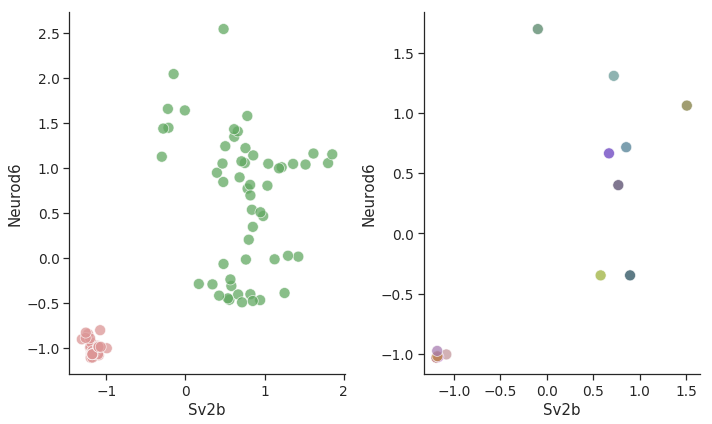

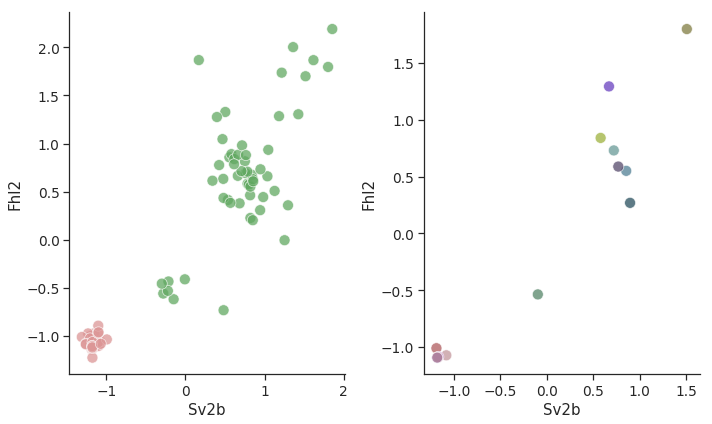

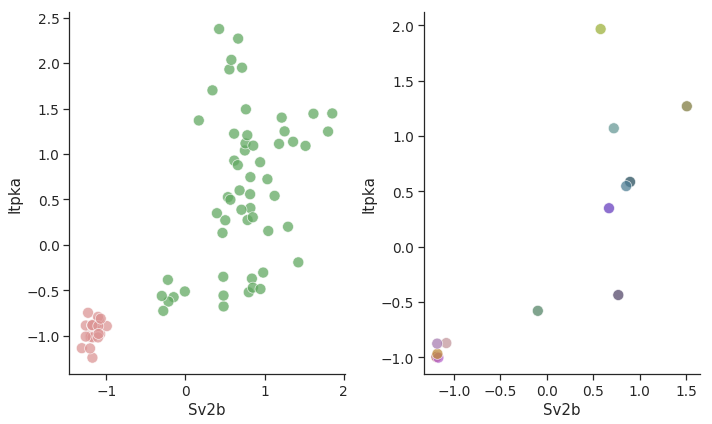

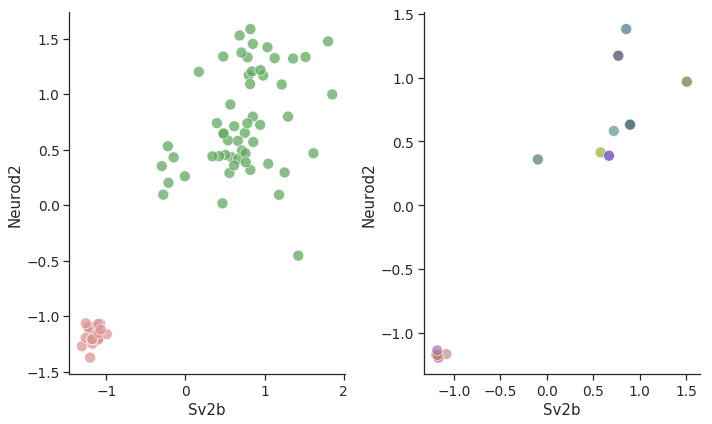

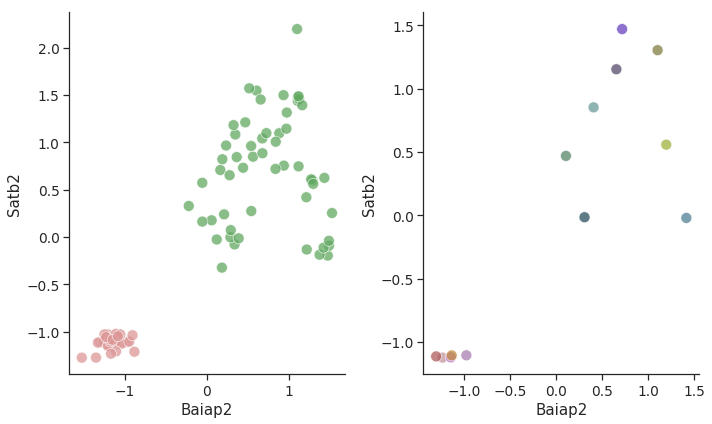

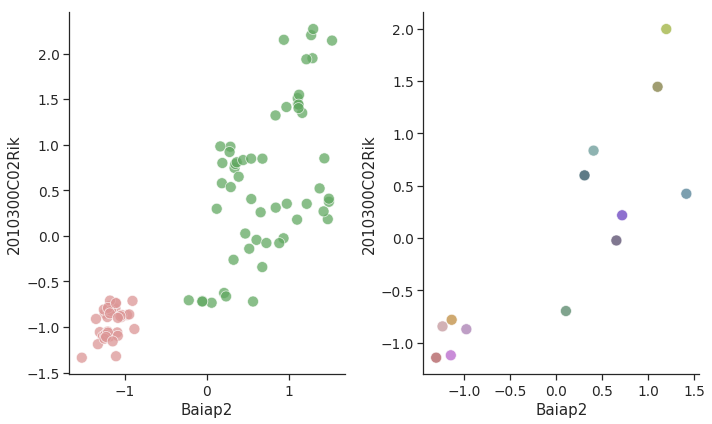

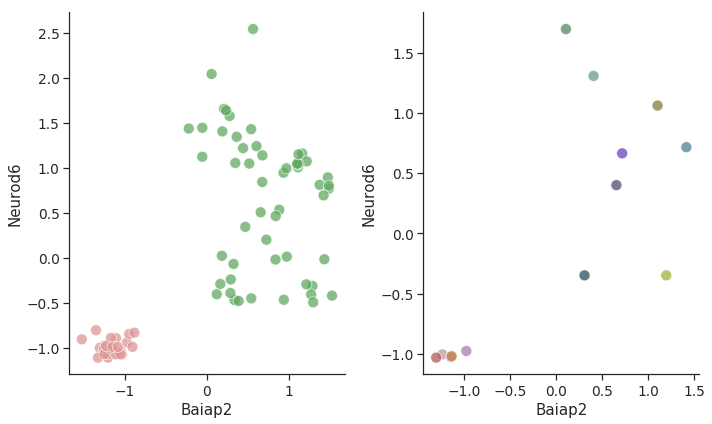

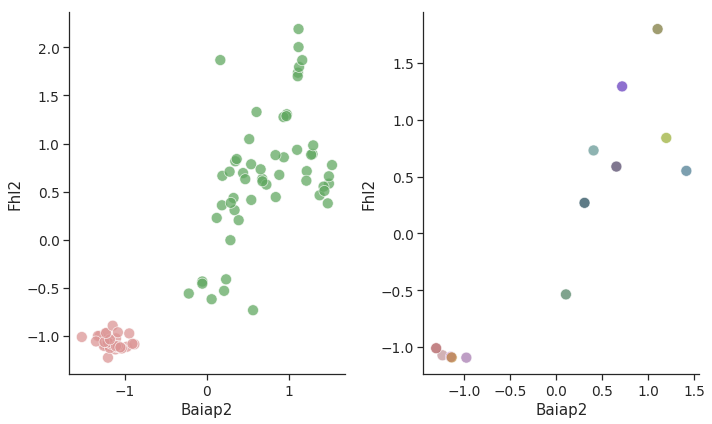

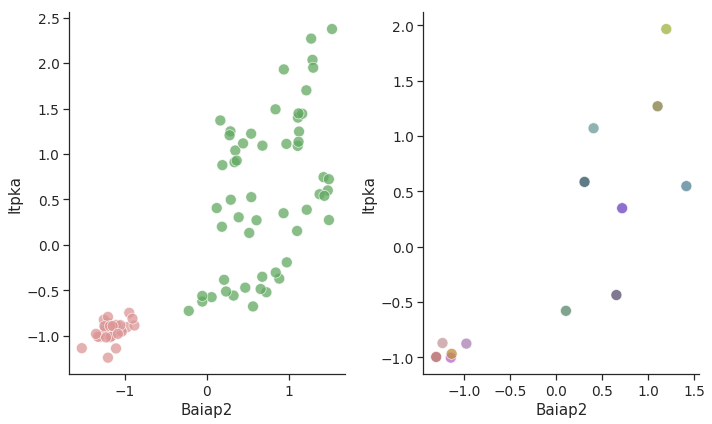

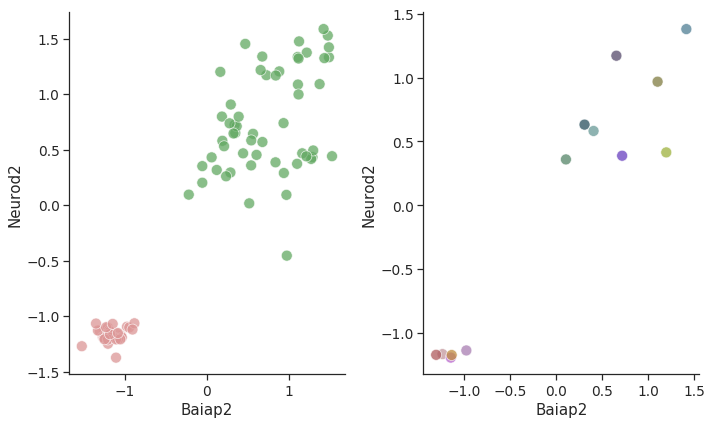

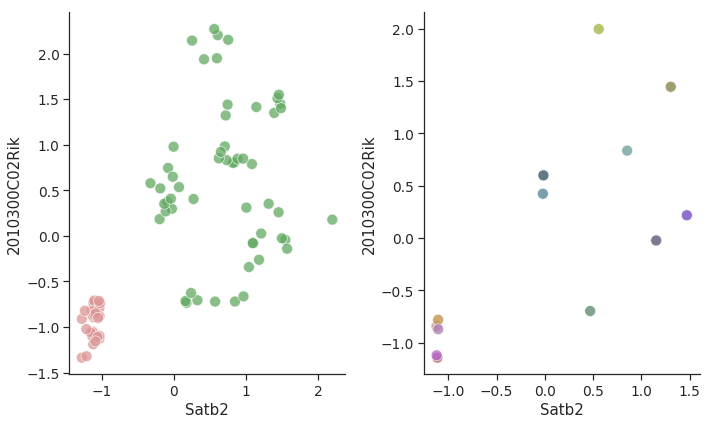

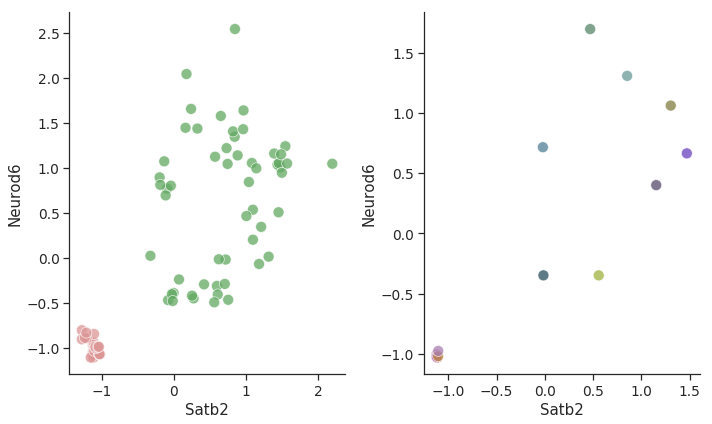

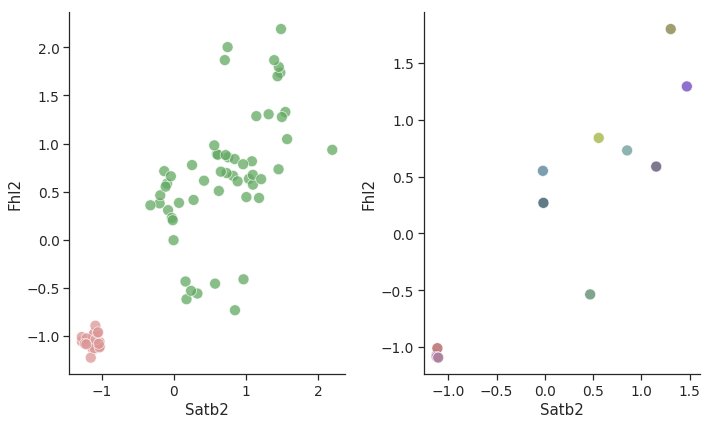

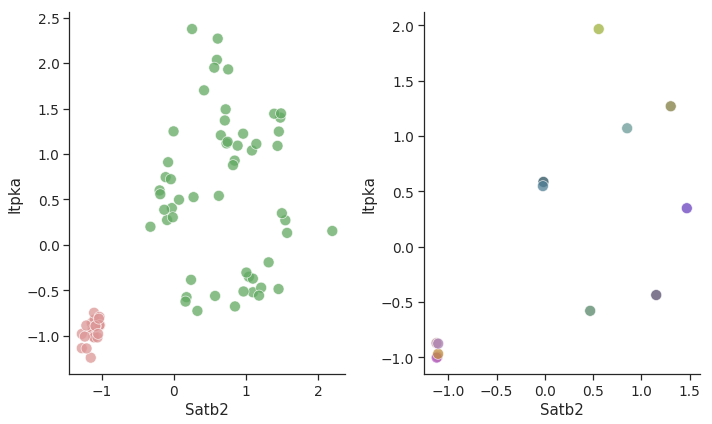

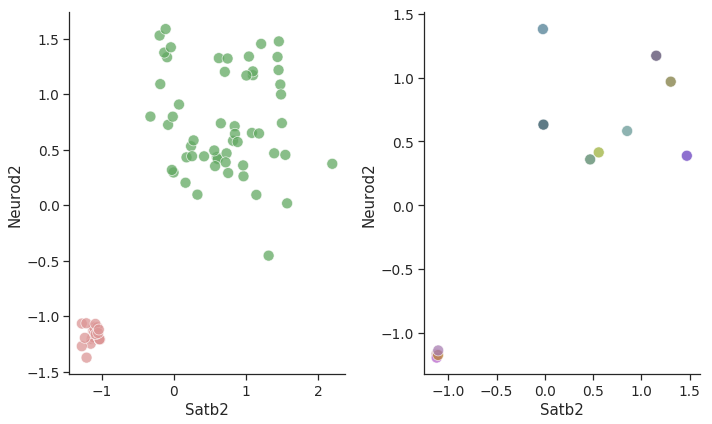

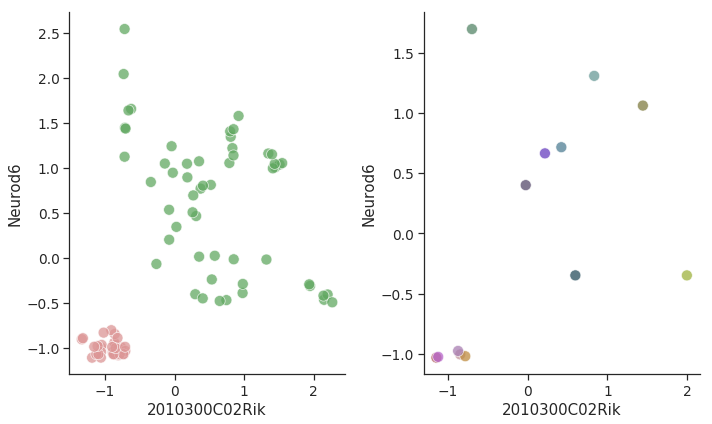

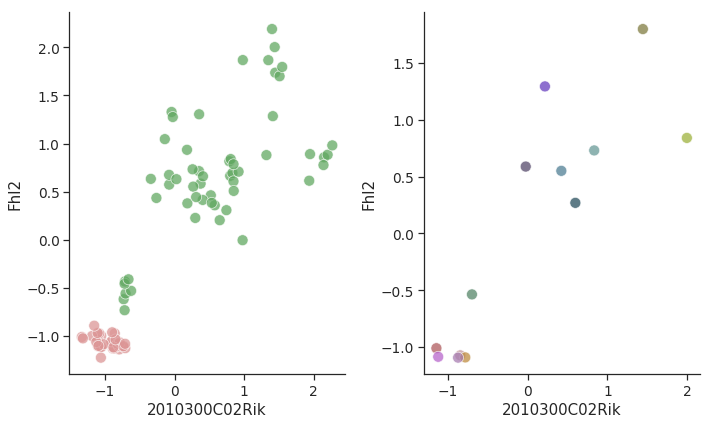

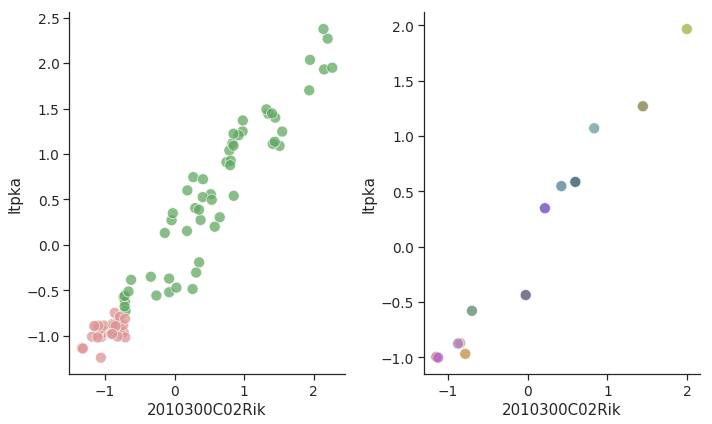

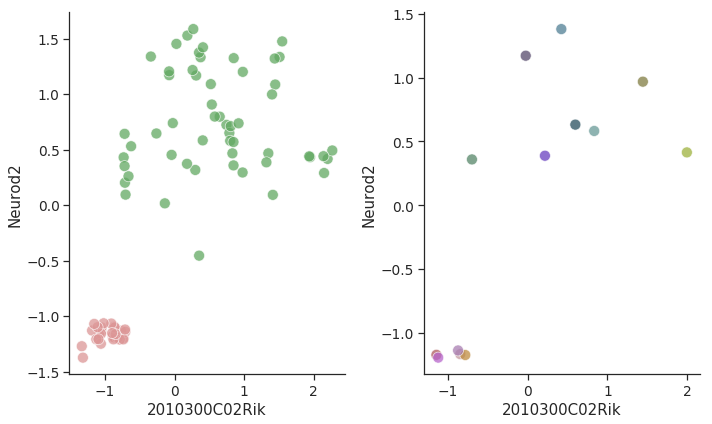

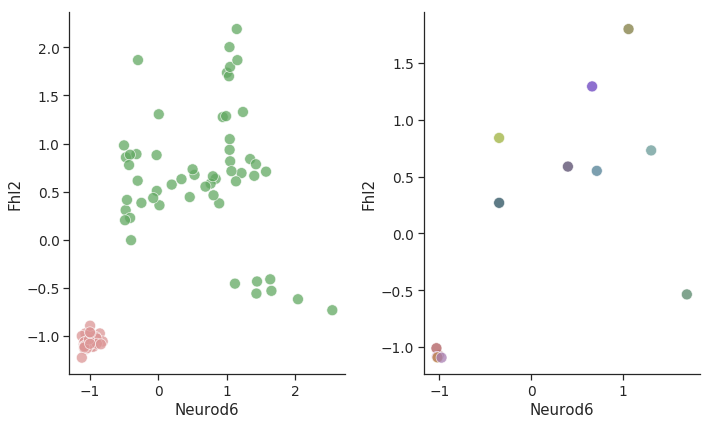

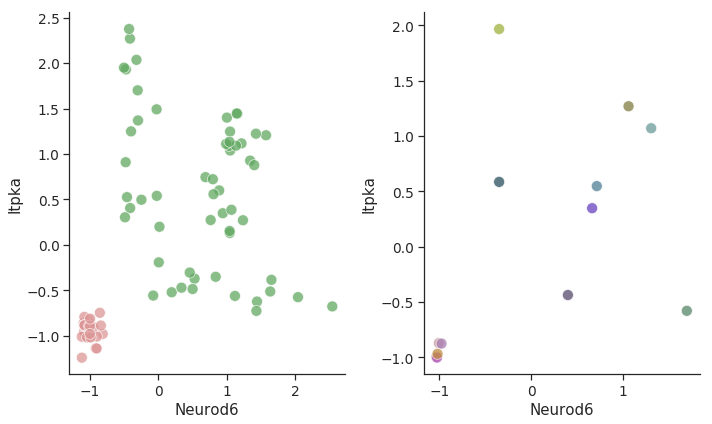

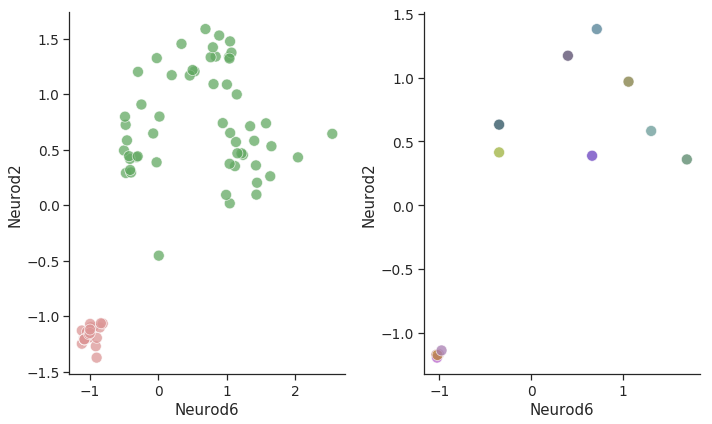

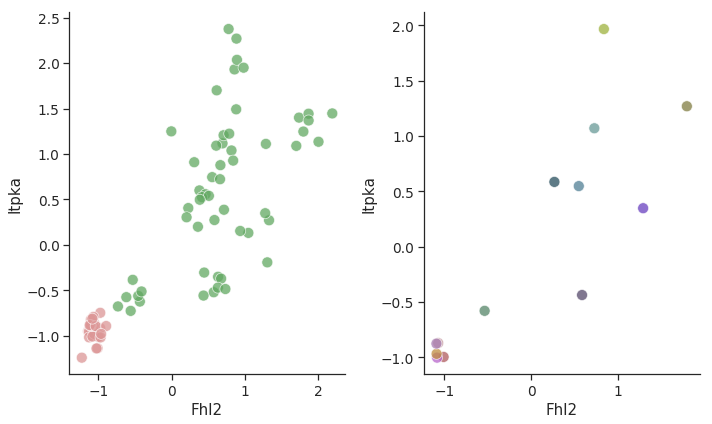

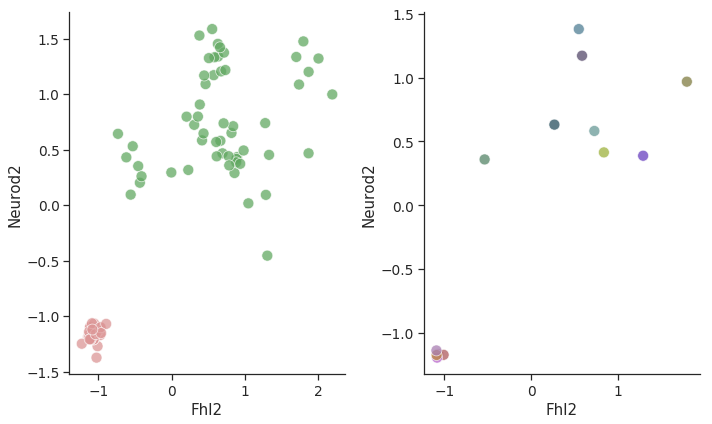

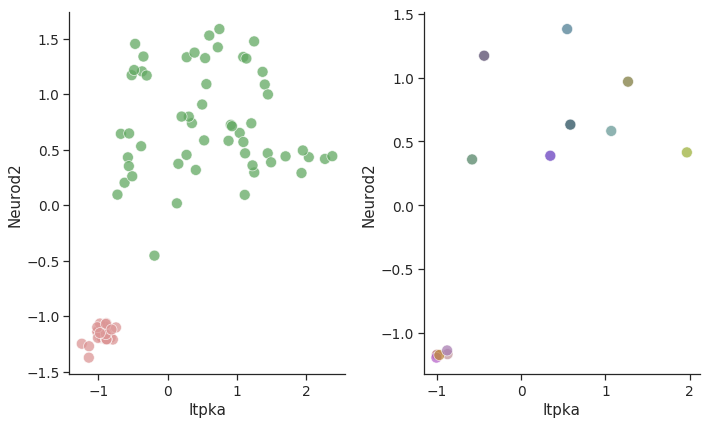

In [1587]:
for g1 ,g2 in glut_comb:
    fig, ax = plt.subplots(figsize=(10,6), ncols=2)
    plot_class_label_scatter(top_genes,g1,g2,ax=ax[0])
    plot_class_label_scatter(top_genes,g1,g2,ax=ax[1],color='subclass_label')
    plt.tight_layout()
    plt.show()